In [1]:
%reset -f
import ROOT
import array
import numpy as np
from datetime import datetime
import traceback
# file = ROOT.TFile.Open("/w/hallb-scshelf2102/clas12/ricardos/testinggroovy/ePip.wCentral.pass2.inb.qa.Sp19.rec_clas_006648.evio.00000-00004.hipo.root")
# file = ROOT.TFile.Open("/w/hallb-scshelf2102/clas12/ricardos/testinggroovy/g1_all_data.root")
file = ROOT.TFile.Open("/w/hallb-scshelf2102/clas12/ricardos/Momentum_Corrections/Central_Tracking/Spring2019/Inbending/Single_Pion_Channel_epipN/central_only/central_all.root")

tree = file.Get("h22")
irdf = ROOT.RDataFrame(tree)
pipPAxis = "P_{#pi^{+}}"
pipMMAxis = "MM"
pipPhiAxis = "#phi_{#pi^{+}}"
pipThetaAxis = "#theta_{#pi^{+}}"
pipDpAxis = "#DeltaP_{#pi^{+}}"
print("Number of entries:", irdf.Count().GetValue())
# use this to pick the group you want ot check
groupc = 1
# f_rdf = irdf.Filter(f'component == {com_to_check}')
if (groupc == 1):
    f_rdf = irdf.Filter(f'component > 46 || component < 7')
elif(groupc ==2):
    f_rdf = irdf.Filter(f'component > 6 && component < 15')
elif(groupc ==3):
    f_rdf = irdf.Filter(f'component > 14 && component < 23')
elif(groupc ==4):
    f_rdf = irdf.Filter(f'component > 22 && component < 31')
elif(groupc ==5):
    f_rdf = irdf.Filter(f'component > 30 && component < 39')
elif(groupc ==6):
    f_rdf = irdf.Filter(f'component > 38 && component < 47')
else:
    print("break")
    f_rdf = irdf

# define angles, not all are still used but some of these are, for the phi shift
p_rdf = f_rdf
p_rdf = p_rdf.Define("pipP", "sqrt(pipx*pipx+pipy*pipy+pipz*pipz)")
p_rdf = p_rdf.Define("pipPhi", "((180/3.1415926)*atan2(pipy, pipx))")
p_rdf = p_rdf.Define("pipTheta", "atan2(sqrt(pipx*pipx+pipy*pipy), pipz)*(180/3.1415926)")
p_rdf = p_rdf.Filter("pipTheta > 35")
p_rdf = p_rdf.Define("pipPhiw","""
    double pipPhiW;
    if(pipPhi < 30 && component >20){
        pipPhiW = pipPhi + 360;
        }
    else{
        pipPhiW = pipPhi;
        }
    return pipPhiW;
""")


Welcome to JupyROOT 6.22/06
Number of entries: 145133352


In [2]:
def print_rounded_str(number=0, rounding=0):

        #if(rounding != 0 and type(number) is not str and (abs(number) > 10**(-abs(rounding-round_science)) or abs(number) >= 0.001)):
    if(rounding != 0 and abs(number) >= 0.001):
        output = round(number, rounding)
        output = "".join(["{:.", str(rounding), "}"]).format(float(number))
        # print("round")
    elif(rounding != 0):
        output = "".join(["{:.", str(rounding-1), "e}"]).format(float(number))
        # print("science")
    else:
        # print("other")
        output = number

    return output

In [3]:
# this is not as important except for make electron plots
rdf = p_rdf.Define("el", "sqrt(ex*ex + ey*ey + ez*ez)")
##=====##       Polar Angles       ##=====##
# rdf = rdf.Define("elth", "atan2(sqrt(ex*ex + ey*ey), ez)*(180/3.1415926)")
# if("Central" in str(pass_version)):
#     print(color.BOLD, "\nMAKING CUT ON ELECTRON POLAR ANGLE TO SELECT THE EVENTS FROM THE 'Central' DETECTOR\n", color.END)
#     rdf = rdf.Filter("elth > 35 && elth < 135")
#             if("Forward" in str(pass_version)):
#                 print(color.BOLD, "\nMAKING CUT ON ELECTRON POLAR ANGLE TO SELECT THE EVENTS FROM THE 'Forward' DETECTOR\n", color.END)
#                 rdf = rdf.Filter("elth >  5 && elth <  35")
##=====##     Azimuthal Angles     ##=====##
rdf = rdf.Define("elPhi", """
    double elPhi = (180/3.1415926)*atan2(ey, ex);
    if(((esec == 4 || esec == 3) && elPhi < 0) || (esec > 4 && elPhi < 90)){
        elPhi += 360;
    }
    return elPhi;
""")
rdf = rdf.Define("localelPhi", "elPhi - (esec - 1)*60")
rdf = rdf.Define("localelPhiS", "localelPhi - (30/el)")
# rdf = rdf.Define("elPhiS", "elPhi - (30/el)")
#rdf = rdf.Define("elPhiNS", "(180/3.1415926)*atan2(ey, ex)") # 'NS' ==> No shifts (distribution will be from ±180˚)

In [4]:
# exclusivity cuts from Richard for central detector
Calculated_Exclusive_Cuts = "".join(["""
        auto beam = ROOT::Math::PxPyPzMVector(0, 0, 10.1998, 0);
        auto targ = ROOT::Math::PxPyPzMVector(0, 0, 0, 0.938);
        auto ele  = ROOT::Math::PxPyPzMVector(ex, ey, ez, 0);
        auto pip0 = ROOT::Math::PxPyPzMVector(pipx, pipy, pipz, 0.13957);
        auto MM_Vector = beam + targ - ele - pip0;
        auto cut_upper = 1.1;
        auto cut_lower = 0;
        
        // most recent exclusivity cuts 
        if(pipsec == -1){
            if(esec == 1){
                if(localelPhiS > -5 && localelPhiS < 5){
                    // Upper Cut
                    cut_upper = (-0.0592999)*el + (1.5334795);
                    // Lower Cut
                    cut_lower = (0.005)*el + (0.7985106);
                }
                if(localelPhiS < -5){
                    // Upper Cut
                    cut_upper = (-0.0635133)*el + (1.5630763);
                    // Lower Cut
                    cut_lower = (0.005)*el + (0.8075723);
                }
                if(localelPhiS > 5){
                    // Upper Cut
                    cut_upper = (-0.0417367)*el + (1.3671238);
                    // Lower Cut
                    cut_lower = (0.005)*el + (0.799642);
                }
            }
            if(esec == 2){
                if(localelPhiS > -5 && localelPhiS < 5){
                    // Upper Cut
                    cut_upper = (-0.032936)*el + (1.305817);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.8250863);
                }
                if(localelPhiS < -5){
                    // Upper Cut
                    cut_upper = (-0.0487001)*el + (1.4357224);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.8338142);
                }
                if(localelPhiS > 5){
                    // Upper Cut
                    cut_upper = (-0.0426093)*el + (1.3719635);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.8126858);
                }
            }
            if(esec == 3){
                if(localelPhiS > -5 && localelPhiS < 5){
                    // Upper Cut
                    cut_upper = (-0.0509723)*el + (1.4492638);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.822748);
                }
                if(localelPhiS < -5){
                    // Upper Cut
                    cut_upper = (-0.045786)*el + (1.3998097);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.8193907);
                }
                if(localelPhiS > 5){
                    // Upper Cut
                    cut_upper = (-0.0653454)*el + (1.5571954);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.8318872);
                }
            }
            if(esec == 4){
                if(localelPhiS > -5 && localelPhiS < 5){
                    // Upper Cut
                    cut_upper = (-0.0320573)*el + (1.3071999);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.847568);
                }
                if(localelPhiS < -5){
                    // Upper Cut
                    cut_upper = (-0.0493433)*el + (1.4431333);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.8390728);
                }
                if(localelPhiS > 5){
                    // Upper Cut
                    cut_upper = (-0.0546428)*el + (1.4943016);
                    // Lower Cut
                    cut_lower = (1e-05)*el + (0.8534834);
                }
            }
            if(esec == 5){
                if(localelPhiS > -5 && localelPhiS < 5){
                    // Upper Cut
                    cut_upper = (-0.0329613)*el + (1.3060447);
                    // Lower Cut
                    cut_lower = (0.005)*el + (0.8241186);
                }
                if(localelPhiS < -5){
                    // Upper Cut
                    cut_upper = (-0.0500122)*el + (1.4492993);
                    // Lower Cut
                    cut_lower = (-0.005)*el + (0.9087516);
                }
                if(localelPhiS > 5){
                    // Upper Cut
                    cut_upper = (-0.0496823)*el + (1.4346816);
                    // Lower Cut
                    cut_lower = (0.005)*el + (0.8256886);
                }
            }
            if(esec == 6){
                if(localelPhiS > -5 && localelPhiS < 5){
                    // Upper Cut
                    cut_upper = (-0.0229957)*el + (1.2248551);
                    // Lower Cut
                    cut_lower = (-0.005)*el + (0.8887692);
                }
                if(localelPhiS < -5){
                    // Upper Cut
                    cut_upper = (-0.0377501)*el + (1.3408122);
                    // Lower Cut
                    cut_lower = (-0.0021906)*el + (0.8747312);
                }
                if(localelPhiS > 5){
                    // Upper Cut
                    cut_upper = (-0.0553155)*el + (1.4872476);
                    // Lower Cut
                    cut_lower = (-0.005)*el + (0.8852568);
                }
            }
        }

        return (MM_Vector.M() < cut_upper && MM_Vector.M() > cut_lower);

    """])
# uncomment to applie cuts, not needed here as this the missing mass file but do it if curious
# rdf = rdf.Filter(Calculated_Exclusive_Cuts)

In [5]:
# this is the definition for the phi shift, uses pipTheta, pipPhiw, and component 
rdf = rdf.Define("pipPhis","""
    double pipPhis;
    if(component == 1){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (1.166e-04*pipTheta*pipTheta+-0.04825*pipTheta+-3.871) * pow( pipP, (-1.611e-07*pipTheta*pipTheta+0.002026*pipTheta+0.1913) )) + (-5.758e-04*pipTheta*pipTheta+-0.06956*pipTheta+1.589) );
    }
    else if(component == 2){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.242e-04*pipTheta*pipTheta+-0.07664*pipTheta+-3.043) * pow( pipP, (-1.724e-05*pipTheta*pipTheta+0.004304*pipTheta+0.1305) )) + (4.961e-04*pipTheta*pipTheta+-0.2251*pipTheta+13.86) );
    }
    else if(component == 3){    
        pipPhis = pipPhiw - ((-0.08786*pipTheta*pipTheta+23.27*pipTheta+-6.904e+03) * exp( (4.124e-04*pipTheta*pipTheta+-0.08415*pipTheta+-3.433) * pow( pipP, (-2.416e-05*pipTheta*pipTheta+0.00488*pipTheta+0.09128) )) + (5.366e-04*pipTheta*pipTheta+-0.244*pipTheta+21.95) );
    }   
    else if(component == 4){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (2.553e-04*pipTheta*pipTheta+-0.05744*pipTheta+-3.906) * pow( pipP, (4.776e-07*pipTheta*pipTheta+8.033e-04*pipTheta+0.2642) )) + (-3.460e-04*pipTheta*pipTheta+-0.03679*pipTheta+19.92) );
    }
    else if(component == 5){   
        pipPhis = pipPhi - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (2.728e-04*pipTheta*pipTheta+-0.07092*pipTheta+-3.205) * pow( pipP, (-1.118e-05*pipTheta*pipTheta+0.003585*pipTheta+0.1415) )) + (3.321e-04*pipTheta*pipTheta+-0.2123*pipTheta+34.75) );    
    }
    else if(component == 6){   
        pipPhis = pipPhi - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (7.749e-04*pipTheta*pipTheta+-0.1459*pipTheta+-1.065) * pow( pipP, (-6.485e-05*pipTheta*pipTheta+0.01195*pipTheta+-0.1083) )) + (0.003267*pipTheta*pipTheta+-0.5845*pipTheta+52.87) );
    }
    else if(component == 7){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (5.437e-05*pipTheta*pipTheta+-0.05879*pipTheta+-3.322) * pow( pipP, (7.166e-06*pipTheta*pipTheta+0.002839*pipTheta+0.1354) )) + (0.002449*pipTheta*pipTheta+-0.5645*pipTheta+62.28) );
    }
    else if(component == 8){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (5.556e-04*pipTheta*pipTheta+-0.09487*pipTheta+-2.566) * pow( pipP, (-3.641e-05*pipTheta*pipTheta+0.005786*pipTheta+0.07365) )) + (0.003407*pipTheta*pipTheta+-0.5499*pipTheta+68.9) );
    }
    else if(component == 9){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (6.325e-04*pipTheta*pipTheta+-0.1008*pipTheta+-2.522) * pow( pipP, (-4.820e-05*pipTheta*pipTheta+0.00698*pipTheta+0.0523) )) + (0.004262*pipTheta*pipTheta+-0.5979*pipTheta+75.75) );
    }
    else if(component == 10){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.371e-04*pipTheta*pipTheta+-0.08361*pipTheta+-2.959) * pow( pipP, (-1.919e-05*pipTheta*pipTheta+0.003797*pipTheta+0.1503) )) + (0.001185*pipTheta*pipTheta+-0.2597*pipTheta+73.94) );
    }
    else if(component == 11){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.779e-04*pipTheta*pipTheta+-0.08476*pipTheta+-2.797) * pow( pipP, (-2.150e-05*pipTheta*pipTheta+0.004911*pipTheta+0.106) )) + (7.806e-04*pipTheta*pipTheta+-0.2571*pipTheta+82.2) );
    }
    else if(component == 12){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.367e-04*pipTheta*pipTheta+-0.08206*pipTheta+-2.894) * pow( pipP, (-2.620e-05*pipTheta*pipTheta+0.005751*pipTheta+0.08499) )) + (7.258e-04*pipTheta*pipTheta+-0.2592*pipTheta+89.51) );
    }
    else if(component == 13){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (5.200e-04*pipTheta*pipTheta+-0.09301*pipTheta+-2.712) * pow( pipP, (-2.873e-05*pipTheta*pipTheta+0.004892*pipTheta+0.1231) )) + (0.001751*pipTheta*pipTheta+-0.2965*pipTheta+97.26) );
    }
    else if(component == 14){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (2.851e-04*pipTheta*pipTheta+-0.067*pipTheta+-3.575) * pow( pipP, (-3.300e-06*pipTheta*pipTheta+0.001576*pipTheta+0.2508) )) + (-2.418e-04*pipTheta*pipTheta+-0.0634*pipTheta+96.78) );
    }
    else if(component == 15){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (6.391e-05*pipTheta*pipTheta+-0.05454*pipTheta+-3.61) * pow( pipP, (3.099e-06*pipTheta*pipTheta+0.002311*pipTheta+0.1873) )) + (2.847e-04*pipTheta*pipTheta+-0.214*pipTheta+110.1) );
    }
    else if(component == 16){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (2.549e-04*pipTheta*pipTheta+-0.06706*pipTheta+-3.343) * pow( pipP, (-4.955e-06*pipTheta*pipTheta+0.002385*pipTheta+0.1911) )) + (6.827e-04*pipTheta*pipTheta+-0.234*pipTheta+118.5) );
    }   
    else if(component == 17){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.122e-04*pipTheta*pipTheta+-0.06667*pipTheta+-3.511) * pow( pipP, (-1.559e-06*pipTheta*pipTheta+9.241e-04*pipTheta+0.2608) )) + (7.799e-04*pipTheta*pipTheta+-0.1943*pipTheta+123.7) );
    }
    else if(component == 18){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.487e-04*pipTheta*pipTheta+-0.07459*pipTheta+-3.172) * pow( pipP, (-2.213e-05*pipTheta*pipTheta+0.004327*pipTheta+0.133) )) + (0.001043*pipTheta*pipTheta+-0.2602*pipTheta+134.5) );
    }
    else if(component == 19){   
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.784e-04*pipTheta*pipTheta+-0.09061*pipTheta+-2.696) * pow( pipP, (-2.703e-05*pipTheta*pipTheta+0.005993*pipTheta+0.0908) )) + (0.001126*pipTheta*pipTheta+-0.3125*pipTheta+143.1) );
    }
    else if(component == 20){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (6.098e-04*pipTheta*pipTheta+-0.1127*pipTheta+-2.284) * pow( pipP, (-5.144e-05*pipTheta*pipTheta+0.0086*pipTheta+0.02868) )) + (0.002147*pipTheta*pipTheta+-0.3846*pipTheta+150.2) );
    }
    else if(component == 21){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (1.135e-04*pipTheta*pipTheta+-0.02604*pipTheta+-5.011) * pow( pipP, (1.943e-05*pipTheta*pipTheta+-0.00304*pipTheta+0.3879) )) + (-0.00152*pipTheta*pipTheta+0.2159*pipTheta+138.3) );
    }
    else if(component == 22){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.301e-04*pipTheta*pipTheta+-0.07959*pipTheta+-3.047) * pow( pipP, (-4.136e-06*pipTheta*pipTheta+0.002628*pipTheta+0.1877) )) + (6.880e-04*pipTheta*pipTheta+-0.2405*pipTheta+163.5) );
    }
    else if(component == 23){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (5.416e-04*pipTheta*pipTheta+-0.08121*pipTheta+-3.357) * pow( pipP, (-2.010e-05*pipTheta*pipTheta+0.001959*pipTheta+0.241) )) + (0.002603*pipTheta*pipTheta+-0.3265*pipTheta+170.9) );
    }
    else if(component == 24){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (5.171e-04*pipTheta*pipTheta+-0.09415*pipTheta+-2.583) * pow( pipP, (-4.101e-05*pipTheta*pipTheta+0.006931*pipTheta+0.03281) )) + (0.003126*pipTheta*pipTheta+-0.5224*pipTheta+187.9) );
    }
    else if(component == 25){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.246e-04*pipTheta*pipTheta+-0.0711*pipTheta+-3.406) * pow( pipP, (-1.897e-05*pipTheta*pipTheta+0.002847*pipTheta+0.1734) )) + (0.002254*pipTheta*pipTheta+-0.33*pipTheta+188.2) );
    }
    else if(component == 26){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (2.442e-04*pipTheta*pipTheta+-0.0497*pipTheta+-3.896) * pow( pipP, (-3.200e-06*pipTheta*pipTheta+0.001001*pipTheta+0.214) )) + (1.411e-04*pipTheta*pipTheta+-0.08413*pipTheta+190.3) );
    }
    else if(component == 27){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.241e-04*pipTheta*pipTheta+-0.06761*pipTheta+-3.338) * pow( pipP, (-1.577e-05*pipTheta*pipTheta+0.003417*pipTheta+0.1435) )) + (0.00114*pipTheta*pipTheta+-0.2615*pipTheta+203.2) );
    }
    else if(component == 28){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.569e-04*pipTheta*pipTheta+-0.07065*pipTheta+-3.368) * pow( pipP, (-2.469e-05*pipTheta*pipTheta+0.004639*pipTheta+0.1161) )) + (4.478e-04*pipTheta*pipTheta+-0.1482*pipTheta+205.9) );
    }
    else if(component == 29){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.804e-04*pipTheta*pipTheta+-0.07515*pipTheta+-3.258) * pow( pipP, (-3.277e-05*pipTheta*pipTheta+0.00548*pipTheta+0.1004) )) + (0.001172*pipTheta*pipTheta+-0.2554*pipTheta+216.6) );
    }
    else if(component == 30){
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.885e-04*pipTheta*pipTheta+-0.07359*pipTheta+-3.43) * pow( pipP, (-3.157e-06*pipTheta*pipTheta+8.044e-04*pipTheta+0.2732) )) + (0.00103*pipTheta*pipTheta+-0.2171*pipTheta+221.8) );
    }
    else if(component == 31){
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.166e-04*pipTheta*pipTheta+-0.06803*pipTheta+-3.399) * pow( pipP, (-1.460e-05*pipTheta*pipTheta+0.00314*pipTheta+0.1634) )) + (9.521e-04*pipTheta*pipTheta+-0.2423*pipTheta+231.8)));
    }
    else if(component == 32){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.437e-04*pipTheta*pipTheta+-0.0826*pipTheta+-2.997) * pow( pipP, (-2.490e-05*pipTheta*pipTheta+0.004418*pipTheta+0.1266) )) + (0.002071*pipTheta*pipTheta+-0.373*pipTheta+243.0)));
    }
    else if(component == 33){
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.081e-04*pipTheta*pipTheta+-0.08104*pipTheta+-2.983) * pow( pipP, (-1.861e-05*pipTheta*pipTheta+0.003915*pipTheta+0.1358) )) + (0.001467*pipTheta*pipTheta+-0.3164*pipTheta+249.3)));
    }    
    else if(component == 34){    
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.715e-04*pipTheta*pipTheta+-0.09383*pipTheta+-2.546) * pow( pipP, (-4.431e-05*pipTheta*pipTheta+0.007695*pipTheta+0.0196) )) + (0.002528*pipTheta*pipTheta+-0.4864*pipTheta+262.9)));
    }
    else if(component == 35){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.300e-04*pipTheta*pipTheta+-0.08484*pipTheta+-2.948) * pow( pipP, (-3.350e-05*pipTheta*pipTheta+0.00581*pipTheta+0.09291) )) + (0.002028*pipTheta*pipTheta+-0.4035*pipTheta+266.8)));
    }
    else if(component == 36){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.992e-04*pipTheta*pipTheta+-0.1007*pipTheta+-2.625) * pow( pipP, (-3.374e-05*pipTheta*pipTheta+0.006175*pipTheta+0.09927) )) + (0.002703*pipTheta*pipTheta+-0.4823*pipTheta+273.5)));
    }
    else if(component == 37){    
        pipPhis = pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (2.049e-04*pipTheta*pipTheta+-0.04599*pipTheta+-3.925) * pow( pipP, (6.380e-06*pipTheta*pipTheta+-4.307e-04*pipTheta+0.262) )) + (2.059e-04*pipTheta*pipTheta+-0.1249*pipTheta+276.2));
    }
    else if(component == 38){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (8.232e-04*pipTheta*pipTheta+-0.14*pipTheta+-1.462) * pow( pipP, (-5.720e-05*pipTheta*pipTheta+0.009458*pipTheta+0.002741) )) + (0.003422*pipTheta*pipTheta+-0.5596*pipTheta+292.6)));
    }
    else if(component == 39){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.125e-04*pipTheta*pipTheta+-0.05256*pipTheta+-3.921) * pow( pipP, (-8.354e-06*pipTheta*pipTheta+9.204e-04*pipTheta+0.2157) )) + (-2.562e-04*pipTheta*pipTheta+-0.01079*pipTheta+286.3)));
    }
    else if(component == 40){
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.568e-04*pipTheta*pipTheta+-0.07657*pipTheta+-3.211) * pow( pipP, (-2.475e-05*pipTheta*pipTheta+0.003706*pipTheta+0.1416) )) + (0.001796*pipTheta*pipTheta+-0.2838*pipTheta+300.9)));
    }
    else if(component == 41){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.247e-04*pipTheta*pipTheta+-0.08127*pipTheta+-2.997) * pow( pipP, (-2.730e-05*pipTheta*pipTheta+0.004874*pipTheta+0.1053) )) + (0.001769*pipTheta*pipTheta+-0.3425*pipTheta+310.5)));
    }
    else if(component == 42){
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (2.548e-04*pipTheta*pipTheta+-0.05479*pipTheta+-3.749) * pow( pipP, (-1.840e-06*pipTheta*pipTheta+0.001161*pipTheta+0.211) )) + (4.092e-04*pipTheta*pipTheta+-0.145*pipTheta+312.6)));
    }
    else if(component == 43){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (2.917e-04*pipTheta*pipTheta+-0.06175*pipTheta+-3.568) * pow( pipP, (-1.028e-05*pipTheta*pipTheta+0.002379*pipTheta+0.1845) )) + (4.200e-04*pipTheta*pipTheta+-0.1567*pipTheta+320.0)));
    }
    else if(component == 44){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.496e-04*pipTheta*pipTheta+-0.06838*pipTheta+-3.351) * pow( pipP, (-1.405e-05*pipTheta*pipTheta+0.003025*pipTheta+0.1553) )) + (0.001026*pipTheta*pipTheta+-0.2368*pipTheta+330.1)));
    }
    else if(component == 45){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.105e-04*pipTheta*pipTheta+-0.07559*pipTheta+-3.231) * pow( pipP, (-2.346e-05*pipTheta*pipTheta+0.003959*pipTheta+0.144) )) + (0.001657*pipTheta*pipTheta+-0.3037*pipTheta+338.5)));
    }
    else if(component == 46){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.828e-04*pipTheta*pipTheta+-0.07641*pipTheta+-3.17) * pow( pipP, (-2.098e-05*pipTheta*pipTheta+0.004043*pipTheta+0.1399) )) + (0.001148*pipTheta*pipTheta+-0.2726*pipTheta+345.1)));
    }
    else if(component == 47){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (3.867e-04*pipTheta*pipTheta+-0.07497*pipTheta+-3.173) * pow( pipP, (-1.908e-05*pipTheta*pipTheta+0.003626*pipTheta+0.1447) )) + (9.592e-04*pipTheta*pipTheta+-0.236*pipTheta+351.7)));
    }
    else if(component == 48){   
        pipPhis = (pipPhiw - ((-1.320e-14*pipTheta*pipTheta+2.058e-12*pipTheta+-3.5e+03) * exp( (4.593e-04*pipTheta*pipTheta+-0.08187*pipTheta+-2.996) * pow( pipP, (-3.379e-05*pipTheta*pipTheta+0.005417*pipTheta+0.09252) )) + (0.002424*pipTheta*pipTheta+-0.4036*pipTheta+363.8)));
    }
    else{
        pipPhis = pipPhiw;
    }
    return pipPhis;
""")

In [6]:
rdf = rdf.Define("vals","""
    auto ele = ROOT::Math::PxPyPzMVector(ex,ey,ez,0);
    auto pip = ROOT::Math::PxPyPzMVector(pipx,pipy,pipz,0.1395);
    auto beam = ROOT::Math::PxPyPzMVector(0,0,10.1998,0);
    auto targ = ROOT::Math::PxPyPzMVector(0,0,0,0.938);
    auto Beam_Energy = 10.1998;
    //auto centralphicorr =...
    
    
    auto eloss_pip = [&](double pion_p, double pip_theta, double pion_det, bool outbending){
    // momentum loss correction for low momentum pions:
    // input: p = pion momentum in GeV, pip_theta = pion theta in degree, 
    //        pion_det = piond stector (2 = FD, 3 = CD),  outbending = torus polarity
    // output: dp_pion = generated momentum - reconstructed momentum = momentum loss (+) / gain (-)

    double dp_pion = 0.0;

    if(outbending == false){ // INBENDING
        if(pion_det == 2){   // Forward Detector
            if(pip_theta < 27){                                       dp_pion =  0.00342646 + (-0.00282934) *pion_p + (0.00205983)   *pow(pion_p,2) + (-0.00043158)  *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta < 27 && pion_p >= 2.5){                      dp_pion =  0.00342646 + (-0.00282934) *2.5    + (0.00205983)   *pow(2.5,2)    + (-0.00043158)  *pow(2.5,3)    + (0) *pow(2.5,4);}
            if(pip_theta > 27 && pip_theta < 28){                     dp_pion =  0.00328565 + (-0.00376042) *pion_p + (0.00433886)   *pow(pion_p,2) + (-0.00141614)  *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 27 && pip_theta < 28 && pion_p >= 1.83){   dp_pion =  0.00328565 + (-0.00376042) *1.83   + (0.00433886)   *pow(1.83,2)   + (-0.00141614)  *pow(1.83,3)   + (0) *pow(1.83,4);}
            if(pip_theta > 28 && pip_theta < 29){                     dp_pion =  0.00328579 + (-0.00281121) *pion_p + (0.00342749)   *pow(pion_p,2) + (-0.000932614) *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 28 && pip_theta < 29 && pion_p >= 2){      dp_pion =  0.00328579 + (-0.00281121) *2      + (0.00342749)   *pow(2,2)      + (-0.000932614) *pow(2,3)      + (0) *pow(2,4);}
            if(pip_theta > 29 && pip_theta < 30){                     dp_pion =  0.00167358 + (0.00441871)  *pion_p + (-0.000834667) *pow(pion_p,2) + (-0.000137968) *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 29 && pip_theta < 30 && pion_p >= 1.9){    dp_pion =  0.00167358 + (0.00441871)  *1.9    + (-0.000834667) *pow(1.9,2)    + (-0.000137968) *pow(1.9,3)    + (0) *pow(1.9,4);}
            if(pip_theta > 30 && pip_theta < 31){                     dp_pion =  0.00274159 + (0.00635686)  *pion_p + (-0.00380977)  *pow(pion_p,2) + (0.00071627)   *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 30 && pip_theta < 31 && pion_p >= 1.9){    dp_pion =  0.00274159 + (0.00635686)  *1.9    + (-0.00380977)  *pow(1.9,2)    + (0.00071627)   *pow(1.9,3)    + (0) *pow(1.9,4);}
            if(pip_theta > 31 && pip_theta < 32){                     dp_pion =  0.00450241 + (0.00248969)  *pion_p + (-0.00336795)  *pow(pion_p,2) + (0.00111193)   *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 31 && pip_theta < 32 && pion_p >= 1.8){    dp_pion =  0.00450241 + (0.00248969)  *1.8    + (-0.00336795)  *pow(1.8,2)    + (0.00111193)   *pow(1.8,3)    + (0) *pow(1.8,4);}
            if(pip_theta > 32 && pip_theta < 33){                     dp_pion =  0.00505593 + (-0.00246203) *pion_p + (0.00172984)   *pow(pion_p,2) + (-0.000406701) *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 32 && pip_theta < 33 && pion_p >= 1.8){    dp_pion =  0.00505593 + (-0.00246203) *1.8    + (0.00172984)   *pow(1.8,2)    + (-0.000406701) *pow(1.8,3)    + (0) *pow(1.8,4);}
            if(pip_theta > 33 && pip_theta < 34){                     dp_pion =  0.00273402 + (0.00440449)  *pion_p + (-0.00373488)  *pow(pion_p,2) + (0.000996612)  *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 33 && pip_theta < 34 && pion_p >= 1.8){    dp_pion =  0.00273402 + (0.00440449)  *1.8    + (-0.00373488)  *pow(1.8,2)    + (0.000996612)  *pow(1.8,3)    + (0) *pow(1.8,4);}
            if(pip_theta > 34 && pip_theta < 35){                     dp_pion =  0.00333542 + (0.00439874)  *pion_p + (-0.00397776)  *pow(pion_p,2) + (0.00105586)   *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 34 && pip_theta < 35 && pion_p >= 1.8){    dp_pion =  0.00333542 + (0.00439874)  *1.8    + (-0.00397776)  *pow(1.8,2)    + (0.00105586)   *pow(1.8,3)    + (0) *pow(1.8,4);}
            if(pip_theta > 35 && pip_theta < 36){                     dp_pion =  0.00354663 + (0.00565397)  *pion_p + (-0.00513503)  *pow(pion_p,2) + (0.00153346)   *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 35 && pip_theta < 36 && pion_p >= 1.8){    dp_pion =  0.00354663 + (0.00565397)  *1.8    + (-0.00513503)  *pow(1.8,2)    + (0.00153346)   *pow(1.8,3)    + (0) *pow(1.8,4);}
            if(pip_theta > 36 && pip_theta < 37){                     dp_pion =  0.00333909 + (0.00842367)  *pion_p + (-0.0077321)   *pow(pion_p,2) + (0.0022489)    *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 36 && pip_theta < 37 && pion_p >= 1.8){    dp_pion =  0.00333909 + (0.00842367)  *1.8    + (-0.0077321)   *pow(1.8,2)    + (0.0022489)    *pow(1.8,3)    + (0) *pow(1.8,4);}
            if(pip_theta > 37 && pip_theta < 38){                     dp_pion =  0.00358828 + (0.0112108)   *pion_p + (-0.0133854)   *pow(pion_p,2) + (0.00486924)   *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 37 && pip_theta < 38 && pion_p >= 1.4){    dp_pion =  0.00358828 + (0.0112108)   *1.4    + (-0.0133854)   *pow(1.4,2)    + (0.00486924)   *pow(1.4,3)    + (0) *pow(1.4,4);}
            if(pip_theta > 38 && pip_theta < 39){                     dp_pion =  0.00354343 + (0.0117121)   *pion_p + (-0.0129649)   *pow(pion_p,2) + (0.00455602)   *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 38 && pip_theta < 39 && pion_p >= 1.3){    dp_pion =  0.00354343 + (0.0117121)   *1.3    + (-0.0129649)   *pow(1.3,2)    + (0.00455602)   *pow(1.3,3)    + (0) *pow(1.3,4);}
            if(pip_theta > 39 && pip_theta < 40){                     dp_pion = -0.00194951 + (0.0409713)   *pion_p + (-0.0595861)   *pow(pion_p,2) + (0.0281588)    *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 39 && pip_theta < 40 && pion_p >= 0.9){    dp_pion = -0.00194951 + (0.0409713)   *0.9    + (-0.0595861)   *pow(0.9,2)    + (0.0281588)    *pow(0.9,3)    + (0) *pow(0.9,4);}
            if(pip_theta > 40 && pip_theta < 41){                     dp_pion = -0.0099217  + (0.0808096)   *pion_p + (-0.119836)    *pow(pion_p,2) + (0.0559553)    *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 40 && pip_theta < 41 && pion_p >= 0.75){   dp_pion = -0.0099217  + (0.0808096)   *0.75   + (-0.119836)    *pow(0.75,2)   + (0.0559553)    *pow(0.75,3)   + (0) *pow(0.75,4);}
            if(pip_theta > 41 && pip_theta < 42){                     dp_pion =  0.00854898 + (0.00025037)  *pion_p + (-0.0113992)   *pow(pion_p,2) + (0.0145178)    *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 41 && pip_theta < 42 && pion_p >= 0.65){   dp_pion =  0.00854898 + (0.00025037)  *0.65   + (-0.0113992)   *pow(0.65,2)   + (0.0145178)    *pow(0.65,3)   + (0) *pow(0.65,4);}
            if(pip_theta > 42){                                       dp_pion =  0.00564818 + (0.00706606)  *pion_p + (0.0042602)    *pow(pion_p,2) + (-0.01141)     *pow(pion_p,3) + (0) *pow(pion_p,4);}
            if(pip_theta > 42 && pion_p >= 0.65){                     dp_pion =  0.00564818 + (0.00706606)  *0.65   + (0.0042602)    *pow(0.65,2)   + (-0.01141)     *pow(0.65,3)   + (0) *pow(0.65,4);}
            }
        if(pion_det == 3){  // Central Detector
            if(pip_theta < 39){                                       dp_pion = -0.045      + (-0.102652) + (0.455589) *pion_p + (-0.671635)   *pow(pion_p,2) + (0.303814)   *pow(pion_p,3);}
            if(pip_theta < 39  && pion_p >= 0.7){                     dp_pion = -0.045      + (-0.102652) + (0.455589) *0.7    + (-0.671635)   *pow(0.7,2)    + (0.303814)   *pow(0.7,3);}
            if(pip_theta > 39  && pip_theta < 40){                    dp_pion =  0.0684552  + (-0.766492)              *pion_p + (1.73092)     *pow(pion_p,2) + (-1.46215)   *pow(pion_p,3) + (0.420127) *pow(pion_p,4);}
            if(pip_theta > 39  && pip_theta < 40 && pion_p >= 1.4){   dp_pion =  0.0684552  + (-0.766492)              *1.4    + (1.73092)     *pow(1.4,2)    + (-1.46215)   *pow(1.4,3)    + (0.420127) *pow(1.4,4);}
            if(pip_theta > 40  && pip_theta < 41){                    dp_pion =  0.751549   + (-7.4593)                *pion_p + (26.8037)     *pow(pion_p,2) + (-47.1576)   *pow(pion_p,3) + (43.8527)  *pow(pion_p,4) + (-20.7039) *pow(pion_p,5) + (3.90931)  *pow(pion_p,6);}
            if(pip_theta > 40  && pip_theta < 41 && pion_p >= 1.45){  dp_pion =  0.751549   + (-7.4593)                *1.45   + (26.8037)     *pow(1.45,2)   + (-47.1576)   *pow(1.45,3)   + (43.8527)  *pow(1.45,4)   + (-20.7039) *pow(1.45,5)   + (3.90931)  *pow(1.45,6);}
            if(pip_theta > 41  && pip_theta < 42){                    dp_pion = -1.35043    + (10.0788)                *pion_p + (-30.4829)    *pow(pion_p,2) + (47.7792)    *pow(pion_p,3) + (-40.996)  *pow(pion_p,4) + (18.2662)  *pow(pion_p,5) + (-3.30449) *pow(pion_p,6);}
            if(pip_theta > 41  && pip_theta < 42 && pion_p >= 1.2){   dp_pion = -1.35043    + (10.0788)                *1.2    + (-30.4829)    *pow(1.2,2)    + (47.7792)    *pow(1.2,3)    + (-40.996)  *pow(1.2,4)    + (18.2662)  *pow(1.2,5)    + (-3.30449) *pow(1.2,6);}
            if(pip_theta > 42  && pip_theta < 43){                    dp_pion = -0.0231195  + (0.0744589)              *pion_p + (-0.0807029)  *pow(pion_p,2) + (0.0264266)  *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 42  && pip_theta < 43 && pion_p >= 1.3){   dp_pion = -0.0231195  + (0.0744589)              *1.3    + (-0.0807029)  *pow(1.3,2)    + (0.0264266)  *pow(1.3,3)    + (0)        *pow(1.3,4);}
            if(pip_theta > 43  && pip_theta < 44){                    dp_pion = -0.00979928 + (0.0351043)              *pion_p + (-0.0365865)  *pow(pion_p,2) + (0.00977218) *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 43  && pip_theta < 44 && pion_p >= 1.1){   dp_pion = -0.00979928 + (0.0351043)              *1.1    + (-0.0365865)  *pow(1.1,2)    + (0.00977218) *pow(1.1,3)    + (0)        *pow(1.1,4);}
            if(pip_theta > 44  && pip_theta < 45){                    dp_pion =  0.00108491 + (-0.00924885)            *pion_p + (0.0216431)   *pow(pion_p,2) + (-0.0137762) *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 44  && pip_theta < 45 && pion_p >= 1.1){   dp_pion =  0.00108491 + (-0.00924885)            *1.1    + (0.0216431)   *pow(1.1,2)    + (-0.0137762) *pow(1.1,3)    + (0)        *pow(1.1,4);}
            if(pip_theta > 45  && pip_theta < 55){                    dp_pion =  0.0092263  + (-0.0676178)             *pion_p + (0.168778)    *pow(pion_p,2) + (-0.167463)  *pow(pion_p,3) + (0.05661)  *pow(pion_p,4);}
            if(pip_theta > 45  && pip_theta < 55 && pion_p >= 1.3){   dp_pion =  0.0092263  + (-0.0676178)             *1.3    + (0.168778)    *pow(1.3,2)    + (-0.167463)  *pow(1.3,3)    + (0.05661)  *pow(1.3,4);}
            if(pip_theta > 55  && pip_theta < 65){                    dp_pion =  0.00805642 + (-0.0670962)             *pion_p + (0.188536)    *pow(pion_p,2) + (-0.20571)   *pow(pion_p,3) + (0.0765)   *pow(pion_p,4);}
            if(pip_theta > 55  && pip_theta < 65 && pion_p >= 1.05){  dp_pion =  0.00805642 + (-0.0670962)             *1.05   + (0.188536)    *pow(1.05,2)   + (-0.20571)   *pow(1.05,3)   + (0.0765)   *pow(1.05,4);}
            if(pip_theta > 65  && pip_theta < 75){                    dp_pion =  0.00312202 + (-0.0269717)             *pion_p + (0.0715236)   *pow(pion_p,2) + (-0.0545622) *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 65  && pip_theta < 75 && pion_p >= 0.75){  dp_pion =  0.00312202 + (-0.0269717)             *0.75   + (0.0715236)   *pow(0.75,2)   + (-0.0545622) *pow(0.75,3)   + (0)        *pow(0.75,4);}
            if(pip_theta > 75  && pip_theta < 85){                    dp_pion =  0.00424971 + (-0.0367683)             *pion_p + (0.10417)     *pow(pion_p,2) + (-0.0899651) *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 75  && pip_theta < 85 && pion_p >= 0.65){  dp_pion =  0.00424971 + (-0.0367683)             *0.65   + (0.10417)     *pow(0.65,2)   + (-0.0899651) *pow(0.65,3)   + (0)        *pow(0.65,4);}
            if(pip_theta > 85  && pip_theta < 95){                    dp_pion =  0.00654123 + (-0.0517915)             *pion_p + (0.147888)    *pow(pion_p,2) + (-0.14253)   *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 85  && pip_theta < 95 && pion_p >= 0.5){   dp_pion =  0.00654123 + (-0.0517915)             *0.5    + (0.147888)    *pow(0.5,2)    + (-0.14253)   *pow(0.5,3)    + (0)        *pow(0.5,4);}
            if(pip_theta > 95  && pip_theta < 105){                   dp_pion = -0.00111721 + (0.00478119)             *pion_p + (0.0158753)   *pow(pion_p,2) + (-0.052902)  *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 95  && pip_theta < 105 && pion_p >= 0.45){ dp_pion = -0.00111721 + (0.00478119)             *0.45   + (0.0158753)   *pow(0.45,2)   + (-0.052902)  *pow(0.45,3)   + (0)        *pow(0.45,4);}
            if(pip_theta > 105 && pip_theta < 115){                   dp_pion = -0.00239839 + (0.00790738)             *pion_p + (0.0311713)   *pow(pion_p,2) + (-0.104157)  *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 105 && pip_theta < 115 && pion_p >= 0.35){ dp_pion = -0.00239839 + (0.00790738)             *0.35   + (0.0311713)   *pow(0.35,2)   + (-0.104157)  *pow(0.35,3)   + (0)        *pow(0.35,4);}
            if(pip_theta > 115 && pip_theta < 125){                   dp_pion = -0.00778793 + (0.0256774)              *pion_p + (0.0932503)   *pow(pion_p,2) + (-0.32771)   *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 115 && pip_theta < 125 && pion_p >= 0.35){ dp_pion = -0.00778793 + (0.0256774)              *0.35   + (0.0932503)   *pow(0.35,2)   + (-0.32771)   *pow(0.35,3)   + (0)        *pow(0.35,4);}
            if(pip_theta > 125 && pip_theta < 135){                   dp_pion = -0.00292778 + (-0.00536697)            *pion_p + (-0.00414351) *pow(pion_p,2) + (0.0196431)  *pow(pion_p,3) + (0)        *pow(pion_p,4);}
            if(pip_theta > 125 && pip_theta < 135 && pion_p >= 0.35){ dp_pion = -0.00292778 + (-0.00536697)            *0.35   + (-0.00414351) *pow(0.35,2)   + (0.0196431)  *pow(0.35,3)   + (0)        *pow(0.35,4);}
            }
        }
    if(outbending == true){ // OUTBENDING
        if(pion_det == 2){  // Forward Detector
            if(pip_theta < 27){                                       dp_pion = 0.00389945  + (-0.004062)    *pion_p + (0.00321842)  *pow(pion_p,2) + (-0.000698299) *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta < 27 && pion_p >= 2.3){                      dp_pion = 0.00389945  + (-0.004062)    *2.3    + (0.00321842)  *pow(2.3,2)    + (-0.000698299) *pow(2.3,3)    + (0)          *pow(2.3,4);}
            if(pip_theta > 27 && pip_theta < 28){                     dp_pion = 0.00727132  + (-0.0117989)   *pion_p + (0.00962999)  *pow(pion_p,2) + (-0.00267005)  *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 27 && pip_theta < 28 && pion_p >= 1.7){    dp_pion = 0.00727132  + (-0.0117989)   *1.7    + (0.00962999)  *pow(1.7,2)    + (-0.00267005)  *pow(1.7,3)    + (0)          *pow(1.7,4);}
            if(pip_theta > 28 && pip_theta < 29){                     dp_pion = 0.00844551  + (-0.0128097)   *pion_p + (0.00945956)  *pow(pion_p,2) + (-0.00237992)  *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 28 && pip_theta < 29 && pion_p >= 2){      dp_pion = 0.00844551  + (-0.0128097)   *2      + (0.00945956)  *pow(2,2)      + (-0.00237992)  *pow(2,3)      + (0)          *pow(2,4);}
            if(pip_theta > 29 && pip_theta < 30){                     dp_pion = 0.00959007  + (-0.0139218)   *pion_p + (0.0122966)   *pow(pion_p,2) + (-0.0034012)   *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 29 && pip_theta < 30 && pion_p >= 1.9){    dp_pion = 0.00959007  + (-0.0139218)   *1.9    + (0.0122966)   *pow(1.9,2)    + (-0.0034012)   *pow(1.9,3)    + (0)          *pow(1.9,4);}
            if(pip_theta > 30 && pip_theta < 31){                     dp_pion = 0.00542816  + (-5.10739e-05) *pion_p + (0.000572038) *pow(pion_p,2) + (-0.000488883) *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 30 && pip_theta < 31 && pion_p >= 1.9){    dp_pion = 0.00542816  + (-5.10739e-05) *1.9    + (0.000572038) *pow(1.9,2)    + (-0.000488883) *pow(1.9,3)    + (0)          *pow(1.9,4);}
            if(pip_theta > 31 && pip_theta < 32){                     dp_pion = 0.0060391   + (-0.000516936) *pion_p + (-0.00286595) *pow(pion_p,2) + (0.00136604)   *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 31 && pip_theta < 32 && pion_p >= 1.8){    dp_pion = 0.0060391   + (-0.000516936) *1.8    + (-0.00286595) *pow(1.8,2)    + (0.00136604)   *pow(1.8,3)    + (0)          *pow(1.8,4);}
            if(pip_theta > 32 && pip_theta < 33){                     dp_pion = 0.0140305   + (-0.0285832)   *pion_p + (0.0248799)   *pow(pion_p,2) + (-0.00701311)  *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 32 && pip_theta < 33 && pion_p >= 1.6){    dp_pion = 0.0140305   + (-0.0285832)   *1.6    + (0.0248799)   *pow(1.6,2)    + (-0.00701311)  *pow(1.6,3)    + (0)          *pow(1.6,4);}
            if(pip_theta > 33 && pip_theta < 34){                     dp_pion = 0.010815    + (-0.0194244)   *pion_p + (0.0174474)   *pow(pion_p,2) + (-0.0049764)   *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 33 && pip_theta < 34 && pion_p >= 1.5){    dp_pion = 0.010815    + (-0.0194244)   *1.5    + (0.0174474)   *pow(1.5,2)    + (-0.0049764)   *pow(1.5,3)    + (0)          *pow(1.5,4);}
            if(pip_theta > 34 && pip_theta < 35){                     dp_pion = 0.0105522   + (-0.0176248)   *pion_p + (0.0161142)   *pow(pion_p,2) + (-0.00472288)  *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 34 && pip_theta < 35 && pion_p >= 1.6){    dp_pion = 0.0105522   + (-0.0176248)   *1.6    + (0.0161142)   *pow(1.6,2)    + (-0.00472288)  *pow(1.6,3)    + (0)          *pow(1.6,4);}
            if(pip_theta > 35 && pip_theta < 36){                     dp_pion = 0.0103938   + (-0.0164003)   *pion_p + (0.0164045)   *pow(pion_p,2) + (-0.00517012)  *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 35 && pip_theta < 36 && pion_p >= 1.5){    dp_pion = 0.0103938   + (-0.0164003)   *1.5    + (0.0164045)   *pow(1.5,2)    + (-0.00517012)  *pow(1.5,3)    + (0)          *pow(1.5,4);}
            if(pip_theta > 36 && pip_theta < 37){                     dp_pion = 0.0441471   + (-0.183937)    *pion_p + (0.338784)    *pow(pion_p,2) + (-0.298985)    *pow(pion_p,3) + (0.126905)   *pow(pion_p,4) + (-0.0208286) *pow(pion_p,5);}
            if(pip_theta > 36 && pip_theta < 37 && pion_p >= 1.8){    dp_pion = 0.0441471   + (-0.183937)    *1.8    + (0.338784)    *pow(1.8,2)    + (-0.298985)    *pow(1.8,3)    + (0.126905)   *pow(1.8,4)    + (-0.0208286) *pow(1.8,5);}
            if(pip_theta > 37 && pip_theta < 38){                     dp_pion = 0.0726119   + (-0.345004)    *pion_p + (0.697789)    *pow(pion_p,2) + (-0.685948)    *pow(pion_p,3) + (0.327195)   *pow(pion_p,4) + (-0.0605621) *pow(pion_p,5);}
            if(pip_theta > 37 && pip_theta < 38 && pion_p >= 1.7){    dp_pion = 0.0726119   + (-0.345004)    *1.7    + (0.697789)    *pow(1.7,2)    + (-0.685948)    *pow(1.7,3)    + (0.327195)   *pow(1.7,4)    + (-0.0605621) *pow(1.7,5);}
            if(pip_theta > 38 && pip_theta < 39){                     dp_pion = 0.0247648   + (-0.0797376)   *pion_p + (0.126535)    *pow(pion_p,2) + (-0.086545)    *pow(pion_p,3) + (0.0219304)  *pow(pion_p,4);}
            if(pip_theta > 38 && pip_theta < 39 && pion_p >= 1.6){    dp_pion = 0.0247648   + (-0.0797376)   *1.6    + (0.126535)    *pow(1.6,2)    + (-0.086545)    *pow(1.6,3)    + (0.0219304)  *pow(1.6,4);}
            if(pip_theta > 39 && pip_theta < 40){                     dp_pion = 0.0208867   + (-0.0492068)   *pion_p + (0.0543187)   *pow(pion_p,2) + (-0.0183393)   *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 39 && pip_theta < 40 && pion_p >= 1.2){    dp_pion = 0.0208867   + (-0.0492068)   *1.2    + (0.0543187)   *pow(1.2,2)    + (-0.0183393)   *pow(1.2,3)    + (0)          *pow(1.2,4);}
            if(pip_theta > 40 && pip_theta < 41){                     dp_pion = 0.0148655   + (-0.0203483)   *pion_p + (0.00835867)  *pow(pion_p,2) + (0.00697134)   *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 40 && pip_theta < 41 && pion_p >= 1.0){    dp_pion = 0.0148655   + (-0.0203483)   *1.0    + (0.00835867)  *pow(1.0,2)    + (0.00697134)   *pow(1.0,3)    + (0)          *pow(1.0,4);}
            if(pip_theta > 41 && pip_theta < 42){                     dp_pion = 0.0223585   + (-0.0365262)   *pion_p + (-0.0150027)  *pow(pion_p,2) + (0.0854164)    *pow(pion_p,3) + (-0.0462718) *pow(pion_p,4);}
            if(pip_theta > 41 && pip_theta < 42 && pion_p >= 0.7){    dp_pion = 0.007617;}
            if(pip_theta > 42){                                       dp_pion = 0.0152373   + (-0.0106377)   *pion_p + (-0.0257573)  *pow(pion_p,2) + (0.0344851)    *pow(pion_p,3) + (0)          *pow(pion_p,4);}
            if(pip_theta > 42 && pion_p >= 0.75){                     dp_pion = 0.0152373   + (-0.0106377)   *0.75   + (-0.0257573)  *pow(0.75,2)   + (0.0344851)    *pow(0.75,3)   + (0)          *pow(0.75,4);}
            }
        if(pion_det == 3){ // Central Detector
            if(pip_theta < 39){                                       dp_pion = -0.05        + (-0.0758897) + (0.362231) *pion_p + (-0.542404)   *pow(pion_p,2) + (0.241344)   *pow(pion_p,3);}
            if(pip_theta < 39  && pion_p >= 0.8){                     dp_pion = -0.05        + (-0.0758897) + (0.362231) *0.8    + (-0.542404)   *pow(0.8,2)    + (0.241344)   *pow(0.8,3);}
            if(pip_theta > 39  && pip_theta < 40){                    dp_pion =  0.0355259   + (-0.589712)               *pion_p + (1.4206)      *pow(pion_p,2) + (-1.24179)   *pow(pion_p,3) + (0.365524)  *pow(pion_p,4);}
            if(pip_theta > 39  && pip_theta < 40  && pion_p >= 1.35){ dp_pion =  0.0355259   + (-0.589712)               *1.35   + (1.4206)      *pow(1.35,2)   + (-1.24179)   *pow(1.35,3)   + (0.365524)  *pow(1.35,4);}
            if(pip_theta > 40  && pip_theta < 41){                    dp_pion = -0.252336    + (1.02032)                 *pion_p + (-1.51461)    *pow(pion_p,2) + (0.967772)   *pow(pion_p,3) + (-0.226028) *pow(pion_p,4);}
            if(pip_theta > 40  && pip_theta < 41  && pion_p >= 1.4){  dp_pion = -0.252336    + (1.02032)                 *1.4    + (-1.51461)    *pow(1.4,2)    + (0.967772)   *pow(1.4,3)    + (-0.226028) *pow(1.4,4);}
            if(pip_theta > 41  && pip_theta < 42){                    dp_pion = -0.710129    + (4.49613)                 *pion_p + (-11.01)      *pow(pion_p,2) + (12.9945)    *pow(pion_p,3) + (-7.41641)  *pow(pion_p,4) + (1.63923)   *pow(pion_p,5);}
            if(pip_theta > 41  && pip_theta < 42  && pion_p >= 1.2){  dp_pion = -0.710129    + (4.49613)                 *1.2    + (-11.01)      *pow(1.2,2)    + (12.9945)    *pow(1.2,3)    + (-7.41641)  *pow(1.2,4)    + (1.63923)   *pow(1.2,5);}
            if(pip_theta > 42  && pip_theta < 43){                    dp_pion = -0.0254912   + (0.0851432)               *pion_p + (-0.0968583)  *pow(pion_p,2) + (0.0350334)  *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 42  && pip_theta < 43  && pion_p >= 1.2){  dp_pion = -0.0254912   + (0.0851432)               *1.2    + (-0.0968583)  *pow(1.2,2)    + (0.0350334)  *pow(1.2,3)    + (0)         *pow(1.2,4);}
            if(pip_theta > 43  && pip_theta < 44){                    dp_pion = -0.0115965   + (0.0438726)               *pion_p + (-0.0500474)  *pow(pion_p,2) + (0.0163627)  *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 43  && pip_theta < 44  && pion_p >= 1.4){  dp_pion = -0.0115965   + (0.0438726)               *1.4    + (-0.0500474)  *pow(1.4,2)    + (0.0163627)  *pow(1.4,3)    + (0)         *pow(1.4,4);}
            if(pip_theta > 44  && pip_theta < 45){                    dp_pion =  0.00273414  + (-0.01851)                *pion_p + (0.0377032)   *pow(pion_p,2) + (-0.0226696) *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 44  && pip_theta < 45  && pion_p >= 1){    dp_pion =  0.00273414  + (-0.01851)                *1      + (0.0377032)   *pow(1,2)      + (-0.0226696) *pow(1,3)      + (0)         *pow(1,4);}
            if(pip_theta > 45  && pip_theta < 55){                    dp_pion =  0.0271952   + (-0.25981)                *pion_p + (0.960051)    *pow(pion_p,2) + (-1.76651)   *pow(pion_p,3) + (1.72872)   *pow(pion_p,4) + (-0.856946) *pow(pion_p,5) + (0.167564) *pow(pion_p,6);}
            if(pip_theta > 45  && pip_theta < 55  && pion_p >= 1.4){  dp_pion =  0.0271952   + (-0.25981)                *1.4    + (0.960051)    *pow(1.4,2)    + (-1.76651)   *pow(1.4,3)    + (1.72872)   *pow(1.4,4)    + (-0.856946) *pow(1.4,5)    + (0.167564) *pow(1.4,6);}
            if(pip_theta > 55  && pip_theta < 65){                    dp_pion =  0.00734975  + (-0.0598841)              *pion_p + (0.161495)    *pow(pion_p,2) + (-0.1629)    *pow(pion_p,3) + (0.0530098) *pow(pion_p,4);}
            if(pip_theta > 55  && pip_theta < 65  && pion_p >= 1.2){  dp_pion =  0.00734975  + (-0.0598841)              *1.2    + (0.161495)    *pow(1.2,2)    + (-0.1629)    *pow(1.2,3)    + (0.0530098) *pow(1.2,4);}
            if(pip_theta > 65  && pip_theta < 75){                    dp_pion =  0.00321351  + (-0.0289322)              *pion_p + (0.0786484)   *pow(pion_p,2) + (-0.0607041) *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 65  && pip_theta < 75  && pion_p >= 0.95){ dp_pion =  0.00321351  + (-0.0289322)              *0.95   + (0.0786484)   *pow(0.95,2)   + (-0.0607041) *pow(0.95,3)   + (0)         *pow(0.95,4);}
            if(pip_theta > 75  && pip_theta < 85){                    dp_pion =  0.00644253  + (-0.0543896)              *pion_p + (0.148933)    *pow(pion_p,2) + (-0.1256)    *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 75  && pip_theta < 85  && pion_p >= 0.7){  dp_pion =  0.00644253  + (-0.0543896)              *0.7    + (0.148933)    *pow(0.7,2)    + (-0.1256)    *pow(0.7,3)    + (0)         *pow(0.7,4);}
            if(pip_theta > 85  && pip_theta < 95){                    dp_pion =  0.00671152  + (-0.0537269)              *pion_p + (0.154509)    *pow(pion_p,2) + (-0.147667)  *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 85  && pip_theta < 95  && pion_p >= 0.65){ dp_pion =  0.00671152  + (-0.0537269)              *0.65   + (0.154509)    *pow(0.65,2)   + (-0.147667)  *pow(0.65,3)   + (0)         *pow(0.65,4);}
            if(pip_theta > 95  && pip_theta < 105){                   dp_pion = -0.000709077 + (0.00331818)              *pion_p + (0.0109241)   *pow(pion_p,2) + (-0.0351682) *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 95  && pip_theta < 105 && pion_p >= 0.45){ dp_pion = -0.000709077 + (0.00331818)              *0.45   + (0.0109241)   *pow(0.45,2)   + (-0.0351682) *pow(0.45,3)   + (0)         *pow(0.45,4);}
            if(pip_theta > 105 && pip_theta < 115){                   dp_pion = -0.00260164  + (0.00846919)              *pion_p + (0.0315497)   *pow(pion_p,2) + (-0.105756)  *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 105 && pip_theta < 115 && pion_p >= 0.45){ dp_pion = -0.00260164  + (0.00846919)              *0.45   + (0.0315497)   *pow(0.45,2)   + (-0.105756)  *pow(0.45,3)   + (0)         *pow(0.45,4);}
            if(pip_theta > 115 && pip_theta < 125){                   dp_pion = -0.00544336  + (0.018256)                *pion_p + (0.0664618)   *pow(pion_p,2) + (-0.240312)  *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 115 && pip_theta < 125 && pion_p >= 0.45){ dp_pion = -0.00544336  + (0.018256)                *0.45   + (0.0664618)   *pow(0.45,2)   + (-0.240312)  *pow(0.45,3)   + (0)         *pow(0.45,4);}
            if(pip_theta > 125 && pip_theta < 135){                   dp_pion = -0.00281073  + (-0.00495863)             *pion_p + (-0.00362356) *pow(pion_p,2) + (0.0178764)  *pow(pion_p,3) + (0)         *pow(pion_p,4);}
            if(pip_theta > 125 && pip_theta < 135 && pion_p >= 0.35){ dp_pion = -0.00281073  + (-0.00495863)             *0.35   + (-0.00362356) *pow(0.35,2)   + (0.0178764)  *pow(0.35,3)   + (0)         *pow(0.35,4);}
            }
        }

        return dp_pion;
    };
    
    
    
    auto dppC = [&](float Px, float Py, float Pz, int sec, int ivec, double pip_phi){

        // ivec = 0 --> Electron Corrections
        // ivec = 1 --> Pi+ Corrections
        // ivec = 2 --> Pi- Corrections
        // ivec = 3 --> Proton Corrections

        // Momentum Magnitude
        double pp = sqrt(Px*Px + Py*Py + Pz*Pz);
        //double theta  = atan2(sqrt(Px*Px + Py*Py), Pz)*(180/3.1415926);
        // Initializing the correction factor
        double dp = 0;

        // Defining Phi Angle
        double Phi = (180/3.1415926)*atan2(Py, Px);

        // (Initial) Shift of the Phi Angle (done to realign sectors whose data is separated when plotted from ±180˚)
        if(((sec == 4 || sec == 3) && Phi < 0) || (sec > 4 && Phi < 90)){
            Phi += 360;
        }

        // Getting Local Phi Angle
        double PhiLocal = Phi - (sec - 1)*60;

        // Applying Shift Functions to Phi Angles (local shifted phi = phi)
        double phi = PhiLocal;

        // For Electron Shift
        if(ivec == 0){
            phi = PhiLocal - 30/pp;
        }

        // For π+ Pion
        if(ivec == 1){
        \\passing in the pipPhis as the phi that has been shifted for the pip, need to change to implenet it as a function
            phi = pip_phi;
        }

        if(ivec == 1){ // No π+ Pion Correction
            double dp_pp = 0;
            
            if(component > 46 || component < 7){
                dp_pp = (((-0.002863)*phi*phi+(-0.002732)*phi+(-0.04023))*pp*pp*pp + ((0.009273)*phi*phi+(0.008053)*phi+(0.1246))*pp*pp + ((-0.009397)*phi*phi+(-0.007087)*phi+(-0.1066))*pp + ((0.003809)*phi*phi+(0.00264)*phi+(0.03855)));
            }
            if(component > 6 && component < 15){
                dp_pp = (((-0.001113)*phi*phi+(-4.959e-04)*phi+(-0.02762))*pp*pp*pp + ((0.004073)*phi*phi+(0.001691)*phi+(0.0806))*pp*pp + ((-0.005353)*phi*phi+(-0.002439)*phi+(-0.06215))*pp + ((0.002586)*phi*phi+(0.001471)*phi+(0.0438)));
            }
            if(component > 14 && component < 23){
                dp_pp = (((-0.002017)*phi*phi+(-0.001491)*phi+(-0.02675))*pp*pp*pp + ((0.007106)*phi*phi+(0.005193)*phi+(0.08401))*pp*pp + ((-0.008033)*phi*phi+(-0.005862)*phi+(-0.07509))*pp + ((0.003278)*phi*phi+(0.002489)*phi+(0.04893)));

            }
            if(component > 22 && component < 31){
                dp_pp = (((-0.001621)*phi*phi+(-0.001268)*phi+(-0.02264))*pp*pp*pp + ((0.005602)*phi*phi+(0.004202)*phi+(0.0766))*pp*pp + ((-0.006343)*phi*phi+(-0.00457)*phi+(-0.0797))*pp + ((0.002846)*phi*phi+(0.002062)*phi+(0.03595)));
            }
            if(component > 30 && component < 39){
                dp_pp = (((-0.003845)*phi*phi+(-0.002706)*phi+(-0.03031))*pp*pp*pp + ((0.01357)*phi*phi+(0.009199)*phi+(0.1077))*pp*pp + ((-0.01543)*phi*phi+(-0.01015)*phi+(-0.1154))*pp + ((0.006127)*phi*phi+(0.004119)*phi+(0.04878)));
            }
            if(component > 38 && component < 47){
                dp_pp = (((-0.001113)*phi*phi+(-0.001066)*phi+(-0.02497))*pp*pp*pp + ((0.003764)*phi*phi+(0.003422)*phi+(0.07724))*pp*pp + ((-0.00434)*phi*phi+(-0.003676)*phi+(-0.07076))*pp + ((0.002289)*phi*phi+(0.001861)*phi+(0.03487)));
                
            }
            
            return dp_pp;
        }


        // electron corrections for PASS 2 Spring 2019 (made originally for the forward detector by Richard C.)
        if(ivec == 0){
            if(sec == 1){
                dp = (-4.3927e-04)*pp*pp + (5.8658e-04)*pp + (0.02801);
            }
            if(sec == 2){
                dp = (4.8839e-04)*pp*pp + (-0.01132)*pp + (0.05124);
            }
            if(sec == 3){
                dp = (3.3571e-04)*pp*pp + (-0.01172)*pp + (0.05763);
            }
            if(sec == 4){
                dp = (1.0268e-04)*pp*pp + (-4.8374e-03)*pp + (0.0412);
            }
            if(sec == 5){
                dp = (2.8250e-04)*pp*pp + (-7.9847e-03)*pp + (0.04232);
            }
            if(sec == 6){
                dp = (1.3589e-04)*pp*pp + (-6.7704e-03)*pp + (0.03464);
            }
            if(sec == 1){
                // The CONTINUOUS QUADRATIC function predicted for ∆p_{El} for [Cor = mmRP2 (Refined Pass 2 Correction)][Sector 1] is:
                dp = dp + ((5.0040e-08)*phi*phi + (-8.0456e-07)*phi + (3.3400e-05))*pp*pp + ((-9.3404e-07)*phi*phi + (1.4125e-05)*phi + (-4.8204e-04))*pp + ((3.2155e-06)*phi*phi + (-1.9460e-05)*phi + (0.0017124));
            }
            if(sec == 2){
                // The CONTINUOUS QUADRATIC function predicted for ∆p_{El} for [Cor = mmRP2 (Refined Pass 2 Correction)][Sector 2] is:
                dp = dp + ((-6.7044e-07)*phi*phi + (2.8531e-06)*phi + (2.3486e-05))*pp*pp + ((6.4134e-06)*phi*phi + (-2.8246e-05)*phi + (-3.0853e-04))*pp + ((-1.2267e-05)*phi*phi + (5.9773e-05)*phi + (9.1883e-04));
            }
            if(sec == 3){
                // The CONTINUOUS QUADRATIC function predicted for ∆p_{El} for [Cor = mmRP2 (Refined Pass 2 Correction)][Sector 3] is:
                dp = dp + ((-1.1237e-06)*phi*phi + (-3.3308e-06)*phi + (-1.1274e-05))*pp*pp + ((9.5363e-06)*phi*phi + (1.9525e-05)*phi + (9.1049e-05))*pp + ((-1.6966e-05)*phi*phi + (-3.0262e-05)*phi + (-2.5634e-04));
            }
            if(sec == 4){
                // The CONTINUOUS QUADRATIC function predicted for ∆p_{El} for [Cor = mmRP2 (Refined Pass 2 Correction)][Sector 4] is:
                dp = dp + ((2.5857e-06)*phi*phi + (9.3712e-06)*phi + (-3.2810e-04))*pp*pp + ((-2.8798e-05)*phi*phi + (-1.2463e-04)*phi + (0.0034551))*pp + ((6.1470e-05)*phi*phi + (3.7680e-04)*phi + (-0.0067891));
            }
            if(sec == 5){
                // The CONTINUOUS QUADRATIC function predicted for ∆p_{El} for [Cor = mmRP2 (Refined Pass 2 Correction)][Sector 5] is:
                dp = dp + ((-2.3158e-07)*phi*phi + (1.4747e-06)*phi + (4.3914e-05))*pp*pp + ((1.7677e-07)*phi*phi + (-1.6546e-05)*phi + (-3.7718e-04))*pp + ((8.4806e-06)*phi*phi + (2.7950e-05)*phi + (4.4451e-04));
            }
            if(sec == 6){
                // The CONTINUOUS QUADRATIC function predicted for ∆p_{El} for [Cor = mmRP2 (Refined Pass 2 Correction)][Sector 6] is:
                dp = dp + ((-1.6987e-06)*phi*phi + (-2.5568e-06)*phi + (1.7701e-04))*pp*pp + ((2.1510e-05)*phi*phi + (2.9852e-05)*phi + (-0.0022824))*pp + ((-6.5180e-05)*phi*phi + (-7.1982e-05)*phi + (0.0068033));
            }
        }
        return dp/pp;
    };
    // these are set up for the pip energy loss function use
    auto pipP2 = sqrt(pipx*pipx+pipy*pipy+pipz*pipz);
    auto pipTheta2 = atan2(sqrt(pipx*pipx+pipy*pipy), pipz)*(180/3.1415926);
    
    // pip energy loss applied, f_pip_loss is passed as a ration to fix the pip momentum when passed into the correction fucntion
    auto p_pip_loss = eloss_pip(pipP2, pipTheta2, 3, false);
    auto f_pip_loss = ((pipP2+p_pip_loss)/pipP2);
    // pipCel is used to set up the energy loss corrected momentum without pip momentum corrctions applied 
    auto fpipel = 1; 
    auto pipCel = ROOT::Math::PxPyPzMVector(pipx*f_pip_loss*fpipel, pipy*f_pip_loss*fpipel, pipz*f_pip_loss*fpipel, 0.13957);
    
    auto fpip = dppC(pipx*f_pip_loss, pipy*f_pip_loss, pipz*f_pip_loss, pipsec, 1, pipPhis) + 1;
    auto pipC = ROOT::Math::PxPyPzMVector(pipx*f_pip_loss*fpip, pipy*f_pip_loss*fpip, pipz*f_pip_loss*fpip, 0.13957);
    
    auto fe = dppC(ex, ey, ez, esec, 0, elPhi) + 1;
    //auto fpip = dppC((pipx*f_pip_loss, pipy*f_pip_loss, pipz*f_pip_loss, pipsec, 1, pipPhis) + 1;    
    auto eleC = ROOT::Math::PxPyPzMVector(ex*fe, ey*fe, ez*fe, 0);
    //auto pipC = ROOT::Math::PxPyPzMVector(pipx*fpip, pipy*fpip, pipz*fpip, 0.13957);
    
    double neutronM2 = 0.9396*0.9396;
    double Proton_M  = 0.938;
    double Pion_C_M  = 0.13957;
    
    auto termA = (neutronM2 - (Proton_M*Proton_M) - (Pion_C_M*Pion_C_M))/2;
    auto termB = Proton_M*(Beam_Energy - eleC.P()) - Beam_Energy*eleC.P()*(1 - cos(eleC.Theta()));
    auto termC = ((eleC.P()*cos(ROOT::Math::VectorUtil::Angle(eleC, pipC))) - (Beam_Energy*cos(pipC.Theta())));

    auto sqrtTerm = ((termA - termB)*(termA - termB)) + (Pion_C_M*Pion_C_M)*((termC*termC) - ((Proton_M + Beam_Energy - eleC.P())*(Proton_M + Beam_Energy - eleC.P())));
    auto denominator = ((Proton_M + Beam_Energy - eleC.P()) + termC)*((Proton_M + Beam_Energy - eleC.P()) - termC);
    auto numeratorP = (termA - termB)*termC + (Proton_M + Beam_Energy - eleC.P())*sqrt(sqrtTerm);
    auto numeratorM = (termA - termB)*termC - (Proton_M + Beam_Energy - eleC.P())*sqrt(sqrtTerm);

    auto pip_CalculateP = numeratorP/denominator;
    auto pip_CalculateM = numeratorM/denominator;

    auto pip_Calculate = pip_CalculateP;

    if(abs(pipC.P() - pip_CalculateP) >= abs(pipC.P() - pip_CalculateM)){{
        pip_Calculate = pip_CalculateM;
    }}
    if(abs(pipC.P() - pip_CalculateP) <= abs(pipC.P() - pip_CalculateM)){{
        pip_Calculate = pip_CalculateP;
    }}

    auto dp_cal_final = pip_Calculate - pipC.P();

    auto Final_Output = beam + targ - eleC - pipC;
    std::vector<double> vals = {dp_cal_final, Final_Output.M(), pipC.P(), pipCel.P() };
    return vals;
   
""")

rdf = rdf.Define("dp","vals[0]")
rdf = rdf.Define("MMdp","vals[1]")
rdf = rdf.Define("pipPC","vals[2]")
rdf = rdf.Define("pipPCel","vals[3]")

In [14]:
# set up the data farmes for each bin
# the mm cut here is to get rid of the large peak that can prevents fitting soemtimes when rebinning
nb = rdf
cb = rdf
pb = rdf
nb = nb.Filter("pipPhis > -1.5 && MMdp<1.2")
cb = cb.Filter("pipPhis > -1.5 && pipPhis < 1.5 && MMdp<1.2")
pb = pb.Filter("pipPhis > 1.5 && MMdp<1.2")

In [15]:
# 2d histos to be drawn and used for 1d peak fitting 
mmtnb = f"#pi^{{+}}, MM vs P, group {groupc} negative; {pipPAxis}; {pipMMAxis}"
mmhnb = nb.Histo2D((f"g {groupc} negative", mmtnb, 200, 0.2, 2, 200, 0.5, 1.2), "pipPCel",  "MMdp")
mmtcb = f"#pi^{{+}}, MM vs P, group {groupc} central ; {pipPAxis}; {pipMMAxis}"
mmhcb = cb.Histo2D((f"g {groupc} central ", mmtcb, 200, 0.2, 2, 200, 0.5, 1.2), "pipPCel",  "MMdp")
mmtpb = f"#pi^{{+}}, MM vs P, group {groupc} positive; {pipPAxis}; {pipMMAxis}"
mmhpb = pb.Histo2D((f"g {groupc} positive", mmtpb, 200, 0.2, 2, 200, 0.5, 1.2), "pipPCel",  "MMdp")


In [16]:
print("Defining Missing Mass fits...")

# Meaning of below: h2 is the 2D histogram to be sliced and fit; minR/maxR is the starting/ending point of the slice range, and dR is the increments of increase between each slice 
# g_num is the group number being looked at it, b_num is the bin number negative: 2 center:1 positive:3
def fit2dall(h2, minR, maxR, dR,g_num,b_num):

    hx = h2.ProjectionX()
    hys2, Sigma_Widths = [], []
    gr2, gr2_Sigma, gr2_Cut_Range_Up, gr2_Cut_Range_Down = ROOT.TGraphErrors(), ROOT.TGraphErrors(), ROOT.TGraphErrors(), ROOT.TGraphErrors()
    gr2_V2 = ROOT.TGraphAsymmErrors()
    gr2.SetMarkerStyle(20)
    gr2_V2.SetMarkerStyle(20)
    gr2_Sigma.SetMarkerStyle(20)
    gr2_Cut_Range_Up.SetMarkerStyle(20)
    gr2_Cut_Range_Down.SetMarkerStyle(20)
    FindPeak_x, FindPeak_y = [], []
    while minR+dR <= maxR:
        ib0, ib1 = hx.FindBin(minR), hx.FindBin(minR+dR)
        hy2 = h2.ProjectionY(f"hy{ib1}", ib0, ib1)
        hy2.SetDirectory(0)      
#         hy2.Rebin(2)
        hy2.SetTitle(f"Bin:{str(round(minR, 4))} < {pipPAxis} < {str(round(minR +dR, 4))}")

        hy2.Rebin(2)
        if(minR > 1.5):
            hy2.Rebin(2)
#         if(minR > 1.6):
#             hy2.Rebin(2)
        hys2.append(hy2)
        mu = hy2.GetBinCenter(hy2.GetMaximumBin())
        bin_width_mu = hy2.GetBinWidth(hy2.FindBin(mu))
#         if(MM_type == "epipX" and (mu < 0.5 or mu > 1.15)):
        mu = 0.9396
        bin_width_mu = 2.5*hy2.GetBinWidth(hy2.FindBin(mu))

#         if(MM_type == "eppipX" and (mu < -0.1 or mu > 0.2)):
#             mu = 0
#             print("".join([color.RED, "\nCheck: ", color.BOLD, color.BLUE, str(Slice_Title), color.END, "\nMax bin centered at: ", str(hy2.GetBinCenter(hy2.GetMaximumBin())), "\n"]))
#             bin_width_mu = 2.5*hy2.GetBinWidth(hy2.FindBin(mu))
                
#         if(MM_type == "epX" and (mu < -0.1 or mu > 0.2)):
#             mu = 0        
#             print("".join([color.RED, "\nCheck: ", color.BOLD, color.BLUE, str(Slice_Title), color.END, "\nMax bin centered at: ", str(hy2.GetBinCenter(hy2.GetMaximumBin())), "\n"]))
#             bin_width_mu = 2.5*hy2.GetBinWidth(hy2.FindBin(mu))

        spectrum = ROOT.TSpectrum(5, 2.5)
        nfound = spectrum.Search(hy2, 2)
        fit_function = "gaus(0) + pol1(3)"
#         if(extra_con_1):
#             # print(color.BOLD + "\n" + color.BLUE + str(Slice_Title) + color.END)
#             # print(color.BOLD + color.BLUE + str(h2.GetName()) + color.END + "\n")
#             # fy2 = ROOT.TF1("fy2", str(fit_function), mu - 2*0.065, mu + 2*0.065)
#             fy2 = ROOT.TF1("fy2", str(fit_function), mu - 1*0.065, mu + 1*0.065)
#         elif(extra_con_2 and False):
#             # print(color.BOLD + "\n" + color.BLUE + str(Slice_Title) + color.END)
#             # print(color.BOLD + color.BLUE + str(h2.GetName()) + color.END + "\n")
#             fy2 = ROOT.TF1("fy2", str(fit_function), mu - 3*0.065, mu + 2*0.065)

#         else:
        fy2 = ROOT.TF1("fy2", str(fit_function), mu - 3*0.065, mu + 3*0.065)
        fy2.SetParameter(0, 0.85*hy2.GetBinContent(hy2.FindBin(mu)))
        fy2.SetParLimits(0, 0.65*hy2.GetBinContent(hy2.FindBin(mu)), 1.15*hy2.GetBinContent(hy2.FindBin(mu)))
        fy2.SetParameter(2, 0.1)
        fy2.SetParLimits(2, 0.001, 0.3)
        fy2.SetParName(0, "Constant")
        fy2.SetParName(1, "Mean")
        fy2.SetParName(2, "Sigma")
        fy2.SetParameter(1, mu)        
        fy2.SetParLimits(1, mu - 1.0*bin_width_mu, mu + 1.0*bin_width_mu)
        fy2.SetLineWidth(4)
        if(minR>0.5):
            fy2.SetParLimits(1, mu - 1.0*bin_width_mu, mu + 2*bin_width_mu)
#         if(minR<0.5):
#             peakh = hy2.GetBinContent(hy2.FindBin(mu))
#             fy2.SetParLimits(0, 0.75 * peakh, 1.25 * peakh)
        if(minR>1.5):
            fy2.SetRange(0.7,1.1)
            fy2.SetParLimits(1, mu - 1.2*bin_width_mu, mu + 1.2*bin_width_mu)
        if(("mm0_NoELC" in h2.GetName()) or ("'mmEF_PipMMEF'" in h2.GetName()) or ("'mmEF_PipMMEF_NoELC'" in h2.GetName())):
            hy2.Fit(fy2, "NBRQ")
        else:
            hy2.Fit(fy2, "BRQ")
        if(minR<0.5):
            mu = fy2.GetParameter(1)
            peakh = hy2.GetBinContent(hy2.FindBin(mu))
            fy2.SetParameter(0, peakh)
#             print(f"{peakh = }")
            fy2.SetParLimits(0, 0.5 * peakh, 1.005 * peakh)
            hy2.Fit(fy2, "BRQ")
          
        sigma_factor = 3
        sigma_factor_up = 1.75
        sigma_factor_down = 2
        
        
        MM_Peak, SIG = fy2.GetParameter(1), abs(fy2.GetParameter(2))
#         print(f"{MM_Peak =}")
#         print(f"{SIG =}\n")
        gr2.SetPoint(gr2.GetN(), minR+dR/2.0, MM_Peak)
        gr2_V2.SetPoint(gr2_V2.GetN(), minR+dR/2.0, MM_Peak)
        
        gr2_Sigma.SetPoint(gr2_Sigma.GetN(), minR+dR/2.0, SIG)
        
        gr2_Cut_Range_Up.SetPoint(gr2_Sigma.GetN(), minR+dR/2.0, MM_Peak + sigma_factor_up*(SIG))
        gr2_Cut_Range_Down.SetPoint(gr2_Sigma.GetN(), minR+dR/2.0, MM_Peak - sigma_factor_down*(SIG))
            
            
        Error_of_MM_Peak = fy2.GetParError(1)
        Error_of_SIG = fy2.GetParError(2)

        gr2.SetPointError(gr2.GetN() - 1, dR/2.0, Error_of_MM_Peak)
        gr2_V2.SetPointError(gr2_V2.GetN() - 1, dR/2.0, Error_of_MM_Peak + sigma_factor_down*(SIG + Error_of_SIG), Error_of_MM_Peak + sigma_factor_up*(SIG + Error_of_SIG))
        
        gr2_Sigma.SetPointError(gr2_Sigma.GetN() - 1, 0, Error_of_SIG)
        
        gr2_Cut_Range_Up.SetPointError(gr2_Cut_Range_Up.GetN() - 1, dR/2.0, Error_of_MM_Peak + sigma_factor_up*(Error_of_SIG))
        gr2_Cut_Range_Down.SetPointError(gr2_Cut_Range_Down.GetN() - 1, dR/2.0, Error_of_MM_Peak + sigma_factor_down*(Error_of_SIG))

        
        FindPeak_x.append(MM_Peak)
        FindPeak_y.append(hy2.GetBinContent(hy2.FindBin(MM_Peak)))

        minR += dR
    
    setattr(h2, "hys2", hys2)
    setattr(h2, "gr2", gr2)
    setattr(h2, "gr2_V2", gr2_V2)
    setattr(h2, "gr2_Sigma", gr2_Sigma)
    setattr(h2, "gr2_Cut_Range_Up", gr2_Cut_Range_Up)
    setattr(h2, "gr2_Cut_Range_Down", gr2_Cut_Range_Down)
    setattr(h2, "FindPeak_x", FindPeak_x)
    setattr(h2, "FindPeak_y", FindPeak_y)
    
    return h2

Defining Missing Mass fits...


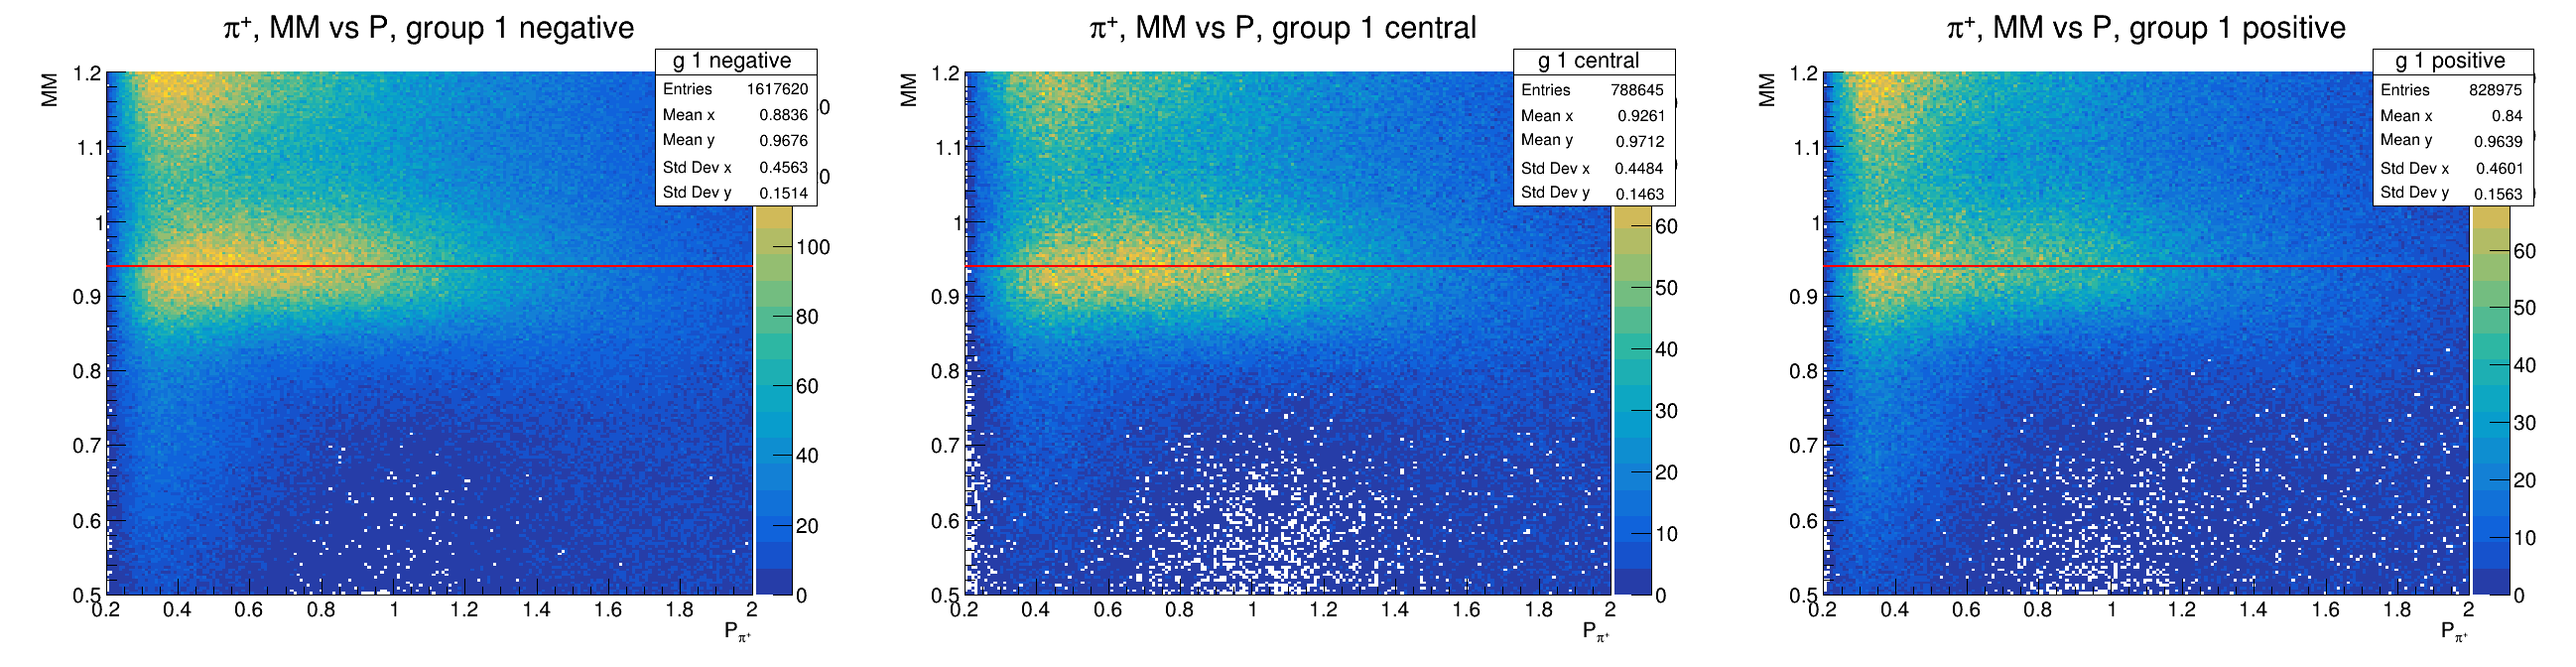

In [ ]:

c_mmb = ROOT.TCanvas("c_sp", "c_sp", 1300*2,700)
c_mmb.Divide(3,1)
c_mmb.cd(1)
# mmhnb.GetYaxis().SetRangeUser(0.9, 1)
mmhnb.Draw("colz")
# mmhnb.gr2.Draw("P Same")
linenb = ROOT.TLine(mmhnb.GetXaxis().GetXmin(), 0.9396, mmhnb.GetXaxis().GetXmax(), 0.9396)
linenb.SetLineColor(2)
linenb.SetLineWidth(2)
linenb.SetLineStyle(1)
linenb.Draw("SAME")
c_mmb.cd(2)
# mmhcb.GetYaxis().SetRangeUser(0.9, 1)
mmhcb.Draw("colz")
# mmhcb.gr2.Draw("P Same")
linecb = ROOT.TLine(mmhcb.GetXaxis().GetXmin(), 0.9396, mmhcb.GetXaxis().GetXmax(), 0.9396)
linecb.SetLineColor(2)
linecb.SetLineWidth(2)
linecb.SetLineStyle(1)
linecb.Draw("SAME")
c_mmb.cd(3)
# mmhpb.GetYaxis().SetRangeUser(0.9, 1)
mmhpb.Draw("colz")
# mmhpb.gr2.Draw("P Same")
linepb = ROOT.TLine(mmhpb.GetXaxis().GetXmin(), 0.9396, mmhpb.GetXaxis().GetXmax(), 0.9396)
linepb.SetLineColor(2)
linepb.SetLineWidth(2)
linepb.SetLineStyle(1)
linepb.Draw("SAME")
c_mmb.Draw()

In [18]:
fit2dall(mmhnb, 0.2, 2, 0.15, groupc, 2)
fit2dall(mmhcb, 0.2, 2, 0.15, groupc, 1)
fit2dall(mmhpb, 0.2, 2, 0.15, groupc, 3)

<cppyy.gbl.ROOT.RDF.RResultPtr<TH2D> object at 0x56050e0bdbb0>

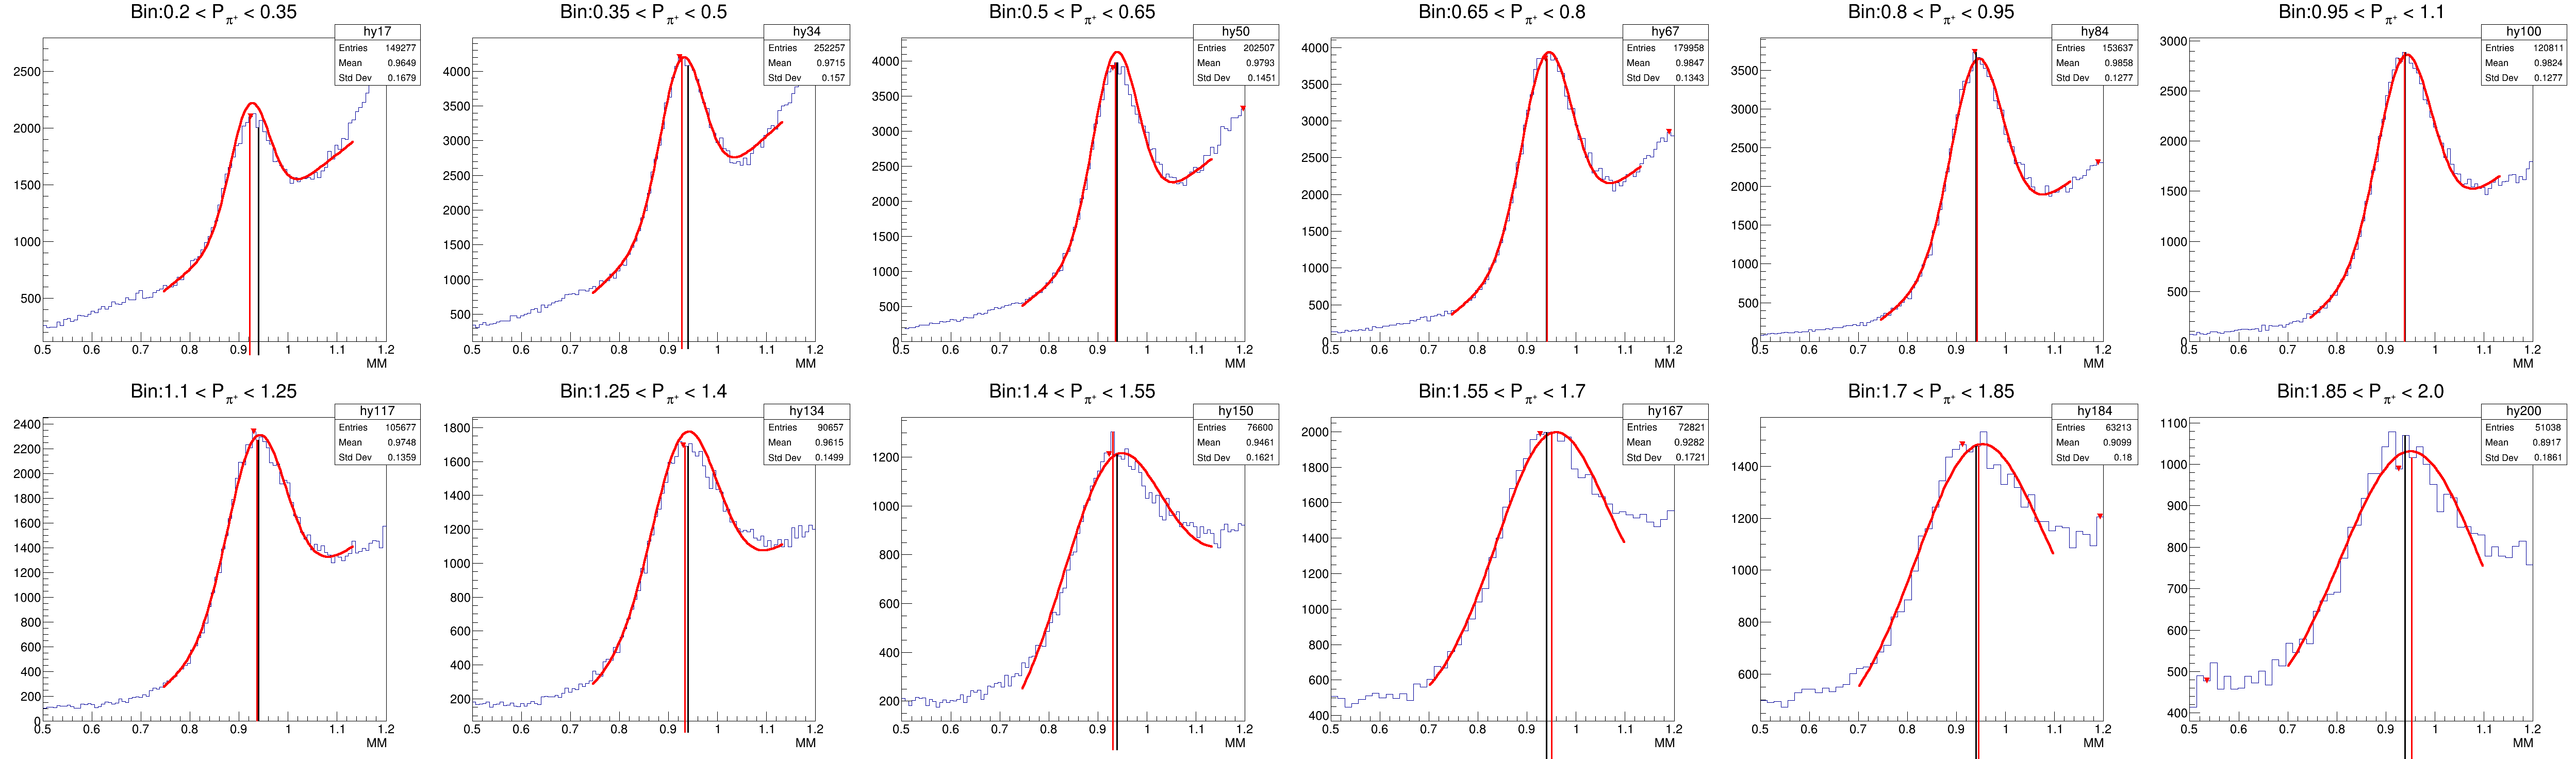

In [19]:
ROOT.gStyle.SetOptFit(0)
cmm_peaks = ROOT.TCanvas("mm_peaks", "mm_peaks", 5000,1500)
cmm_peaks.Divide(6,2,0.0001,0.0001)
cmm_peaks.Draw()
# r = mm_hl[reg_to_check-1].gr2.GetMaximum()
line_peak_x_i = 0.9396

line_list = []
line_list2 = []
for i in range(12):
    line = ROOT.TLine()
    line.SetLineWidth(3)
    line.SetLineStyle(1)
    line_list.append(line)
    line2 = ROOT.TLine()
    
    line2.SetLineWidth(3)
    line2.SetLineStyle(1)
    line2.SetLineColor(2)
    line_list2.append(line2)
# print(len(mm_hl[reg_to_check-1].hys2))
for i in range(12):
    cmm_peaks.cd(i + 1)
    mmhnb.hys2[i].GetXaxis().SetRangeUser(0.5, 1.2)
    mmhnb.hys2[i].Draw()
    mmhnb.hys2[i].SetStats(1)
    line_peak_y_i = mmhnb.hys2[i].GetBinContent(mmhnb.hys2[i].FindBin(line_peak_x_i))
    line_list[i].DrawLine(line_peak_x_i, 0, line_peak_x_i, line_peak_y_i)
    line_list[i].Draw("Same")
    line_peak_x_i2 = mmhnb.FindPeak_x[i]
    line_peak_y_i2 = mmhnb.hys2[i].GetBinContent(mmhnb.hys2[i].FindBin(line_peak_x_i2))
    line_list2[i].DrawLine(line_peak_x_i2, 0, line_peak_x_i2, line_peak_y_i2)
    line_list2[i].Draw("Same")
cmm_peaks.Update()

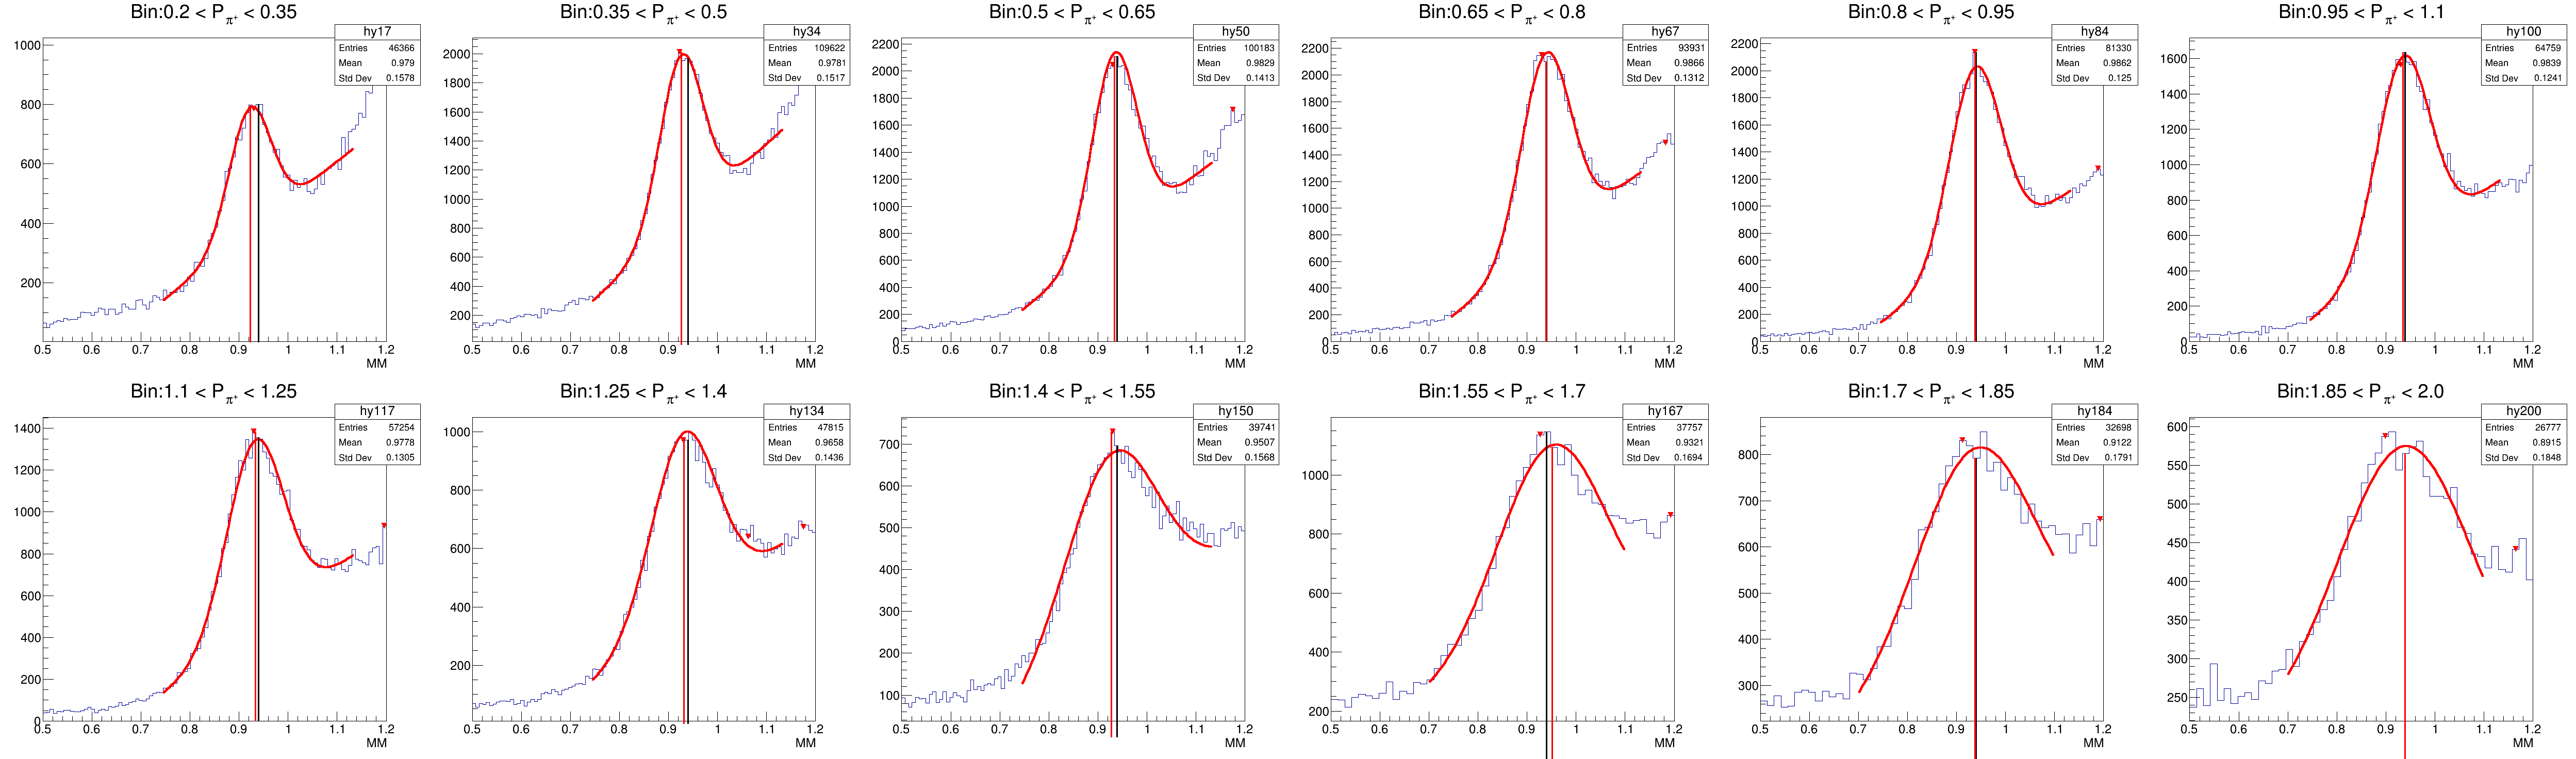

In [20]:
ROOT.gStyle.SetOptFit(0)
cmm_peaks = ROOT.TCanvas("mm_peaks", "mm_peaks", 5000,1500)
cmm_peaks.Divide(6,2,0.0001,0.0001)
cmm_peaks.Draw()
# r = mm_hl[reg_to_check-1].gr2.GetMaximum()
line_peak_x_i = 0.9396

line_list = []
line_list2 = []
for i in range(12):
    line = ROOT.TLine()
    line.SetLineWidth(3)
    line.SetLineStyle(1)
    line_list.append(line)
    line2 = ROOT.TLine()
    
    line2.SetLineWidth(3)
    line2.SetLineStyle(1)
    line2.SetLineColor(2)
    line_list2.append(line2)
# print(len(mm_hl[reg_to_check-1].hys2))
for i in range(12):
    cmm_peaks.cd(i + 1)
    mmhcb.hys2[i].GetXaxis().SetRangeUser(0.5, 1.2)
    mmhcb.hys2[i].Draw()
    mmhcb.hys2[i].SetStats(1)
    line_peak_y_i = mmhcb.hys2[i].GetBinContent(mmhcb.hys2[i].FindBin(line_peak_x_i))
    line_list[i].DrawLine(line_peak_x_i, 0, line_peak_x_i, line_peak_y_i)
    line_list[i].Draw("Same")
    line_peak_x_i2 = mmhcb.FindPeak_x[i]
    line_peak_y_i2 = mmhcb.hys2[i].GetBinContent(mmhcb.hys2[i].FindBin(line_peak_x_i2))
    line_list2[i].DrawLine(line_peak_x_i2, 0, line_peak_x_i2, line_peak_y_i2)
    line_list2[i].Draw("Same")
cmm_peaks.Update()

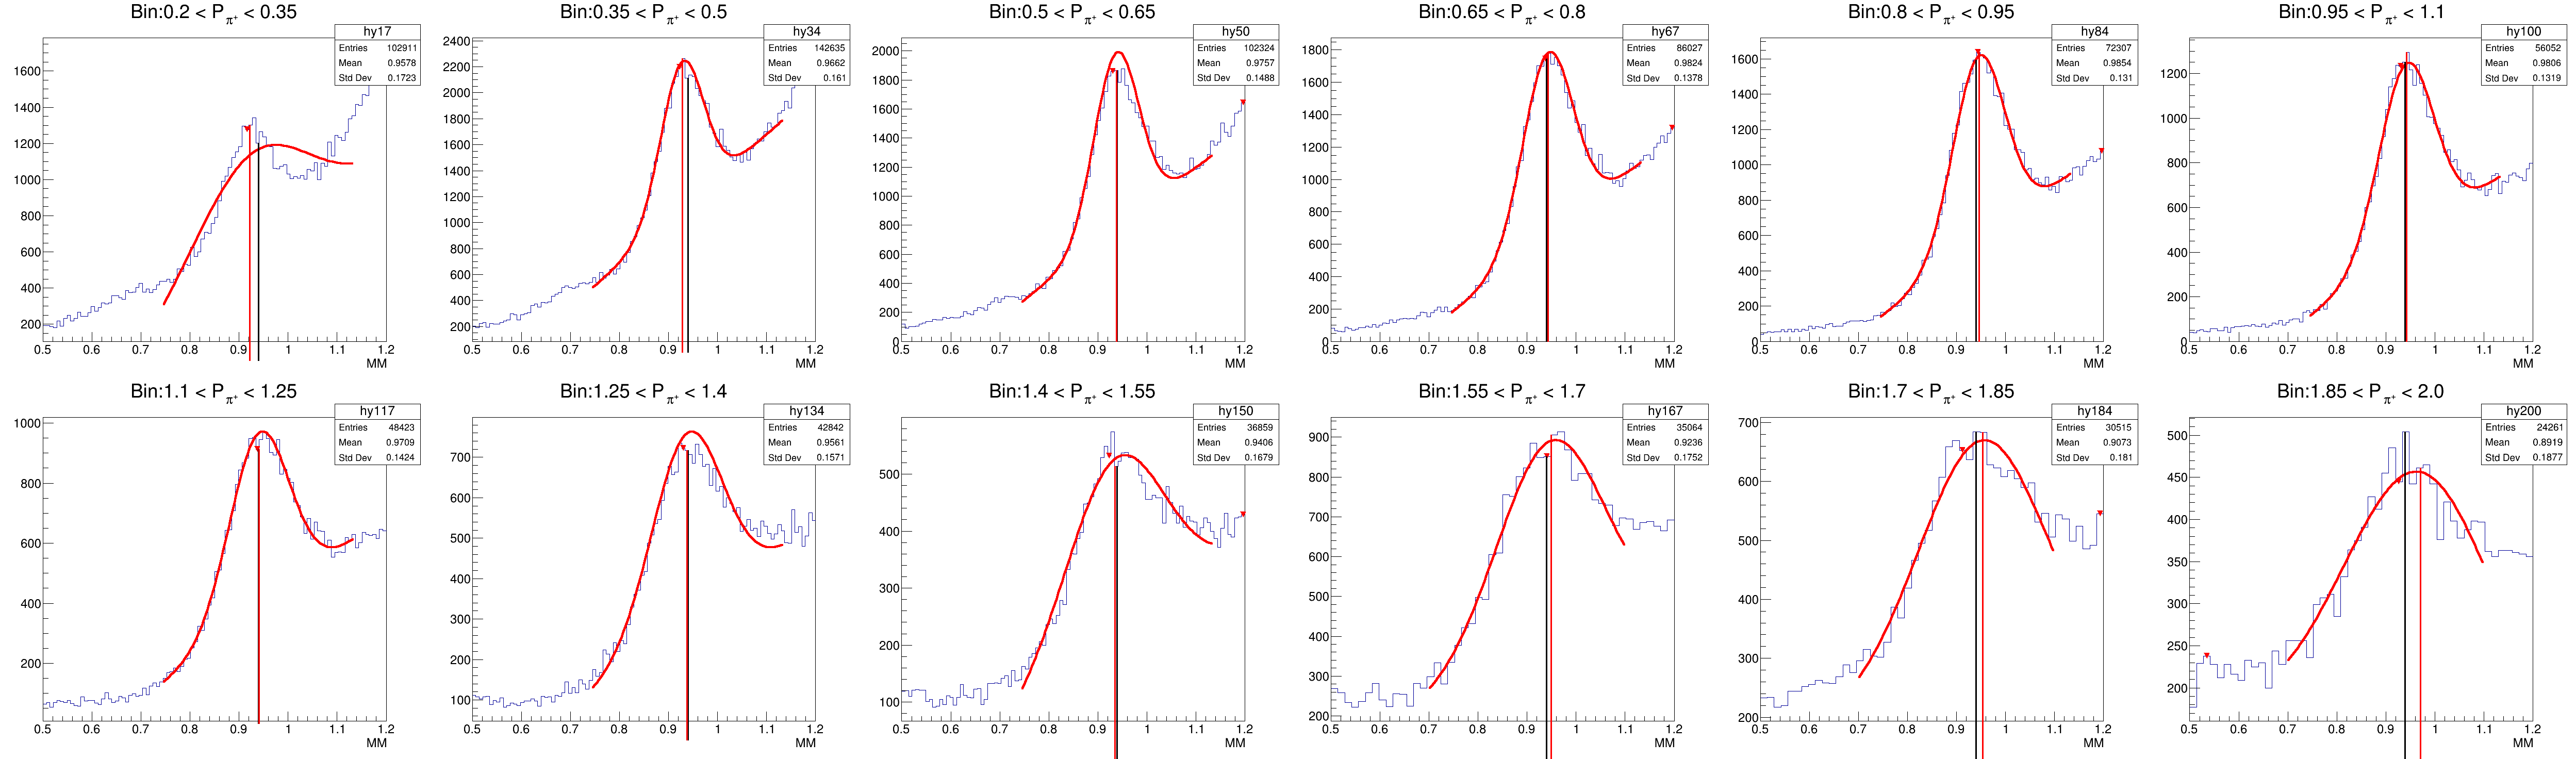

In [21]:
ROOT.gStyle.SetOptFit(0)
cmm_peaks = ROOT.TCanvas("mm_peaks", "mm_peaks", 5000,1500)
cmm_peaks.Divide(6,2,0.0001,0.0001)
cmm_peaks.Draw()
# r = mm_hl[reg_to_check-1].gr2.GetMaximum()
line_peak_x_i = 0.9396

line_list = []
line_list2 = []
for i in range(12):
    line = ROOT.TLine()
    line.SetLineWidth(3)
    line.SetLineStyle(1)
    line_list.append(line)
    line2 = ROOT.TLine()
    
    line2.SetLineWidth(3)
    line2.SetLineStyle(1)
    line2.SetLineColor(2)
    line_list2.append(line2)
# print(len(mm_hl[reg_to_check-1].hys2))
for i in range(12):
    cmm_peaks.cd(i + 1)
    mmhpb.hys2[i].GetXaxis().SetRangeUser(0.5, 1.2)
    mmhpb.hys2[i].Draw()
    mmhpb.hys2[i].SetStats(1)
    line_peak_y_i = mmhpb.hys2[i].GetBinContent(mmhpb.hys2[i].FindBin(line_peak_x_i))
    line_list[i].DrawLine(line_peak_x_i, 0, line_peak_x_i, line_peak_y_i)
    line_list[i].Draw("Same")
    line_peak_x_i2 = mmhpb.FindPeak_x[i]
    line_peak_y_i2 = mmhpb.hys2[i].GetBinContent(mmhpb.hys2[i].FindBin(line_peak_x_i2))
    line_list2[i].DrawLine(line_peak_x_i2, 0, line_peak_x_i2, line_peak_y_i2)
    line_list2[i].Draw("Same")
cmm_peaks.Update()

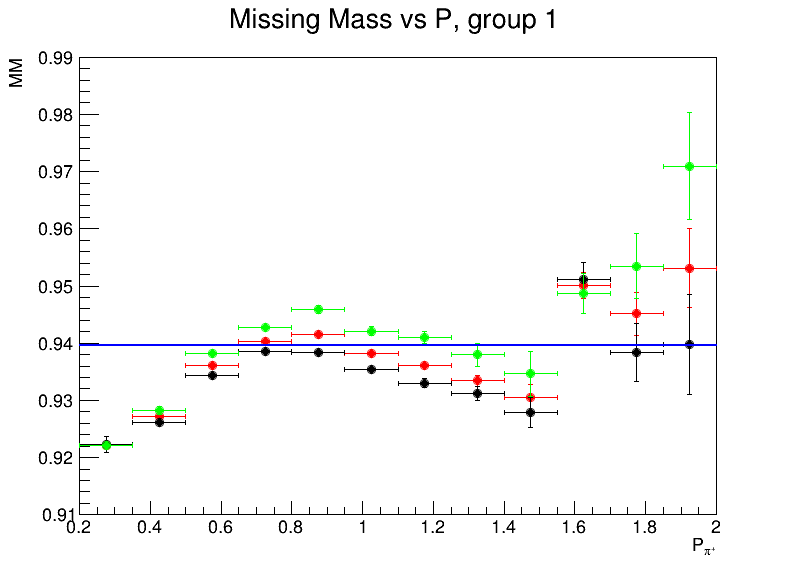

In [23]:
call = ROOT.TCanvas("all", "all", 800, 600)
# call = ROOT.TCanvas("all", "all", 1300, 600)


n_bins_x = 100
x_min = 0.2
x_max =2
n_bins_y = 100
y_min = 0.91
y_max = 0.99
# y_min = -0.15
# y_max = 0.15
histogram = ROOT.TH2F("combined histos", f"Missing Mass vs P, group {groupc};{pipPAxis};{pipMMAxis}",
                      n_bins_x, x_min, x_max,
                      n_bins_y, y_min, y_max)
# histogram.GetXaxis().SetRangeUser(x_min, x_max)
# histogram.GetYaxis().SetRangeUser(y_min, y_max)
# histogram.SetTitle("Your Histogram Title")
ROOT.gStyle.SetLegendTextSize(0.0175)
histogram.SetStats(0)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptFit(0)



legend = ROOT.TLegend(0.775, 0.3, 0.9, 0.1)
legend.SetNColumns(1)

legend.AddEntry(mmhnb.gr2,f"Negative #phi Bin","L")
legend.AddEntry(mmhcb.gr2,f"Central #phi Bin","L")
legend.AddEntry(mmhpb.gr2,f"Positive #phi Bin","L")
#     exec(cpal[i])
# Legend[Legend_Name].AddEntry(histo_search[region_3_Name].gr2_Sigma, "".join(["#color[", str(3 if("mm0" not in Correction_Name) else 8),  "]{#splitline{", "Corrected" if("mm0" not in Correction_Name) else "Uncorrected", "}{Positive #phi Bin}}"]), "p" if("mm0" not in Correction_Name) else "lp")
histogram.Draw()
mmhnb.gr2.SetMarkerColor(2)
mmhcb.gr2.SetMarkerColor(1)
mmhpb.gr2.SetMarkerColor(3)
mmhnb.gr2.SetLineColor(2)
mmhcb.gr2.SetLineColor(1)
mmhpb.gr2.SetLineColor(3)

mmhnb.gr2.Draw("P Same")
mmhcb.gr2.Draw("P Same")
mmhpb.gr2.Draw("P Same")
li = ROOT.TLine(0.2, 0.9396, 2, 0.9396)
li.SetLineColor(4)
li.SetLineWidth(2)
li.SetLineStyle(1)
li.Draw("SAME")
# legend.Draw()

call.Update()

call.Draw()

In [23]:
# stop